<a href="https://colab.research.google.com/github/RobertGrados/RobertGrados/blob/main/SEAS6414_HW8_RGrados_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SEAS 6414 HW8
# This homework focuses on analyzing and forecasting merchant transaction data using
# various time series techniques. The primary objective is to apply different forecasting
# models and evaluate their performance in predicting future transaction volumes.


In [ ]:
cd C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8

[Errno 2] No such file or directory: 'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'
/content


In [ ]:
pwd

'/content'

In [15]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
# Read the data from CSV
# Sets the "time" column as the index. With parse_dates=True argument ensuring dates are parsed correctly
#df = pd.read_csv("homework8.csv", index_col="time", parse_dates=True)
df = pd.read_csv("Homework8.csv", index_col=["time"], parse_dates=["time"])
df.head(10)

# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")]

# Resample data to daily transaction sums
daily_transactions = df.resample("D")["amount_usd_in_cents"].sum()/100  # Total transactions in US Dollars per Day

# Print the resulting DataFrame (optional)
print(daily_transactions.head())

# Save the resampled data (optional)
daily_transactions.to_csv("daily_transactions.csv")

time
2033-01-01     4415.40
2033-01-02     4758.62
2033-01-03     6283.53
2033-01-04     4851.11
2033-01-05    10016.21
Freq: D, Name: amount_usd_in_cents, dtype: float64


In [17]:
df.head()

Unnamed: 0    merchant  amount_usd_in_cents
time                                                            
2034-06-17 23:34:14           1  faa029c6b0                 6349
2034-12-27 00:40:38           2  ed7a7d91aa                 3854
2034-04-30 01:29:42           3  5608f200cf                  789
2034-09-16 01:06:23           4  15b1a0d61e                 4452
2034-07-22 16:21:42           5  4770051790                20203

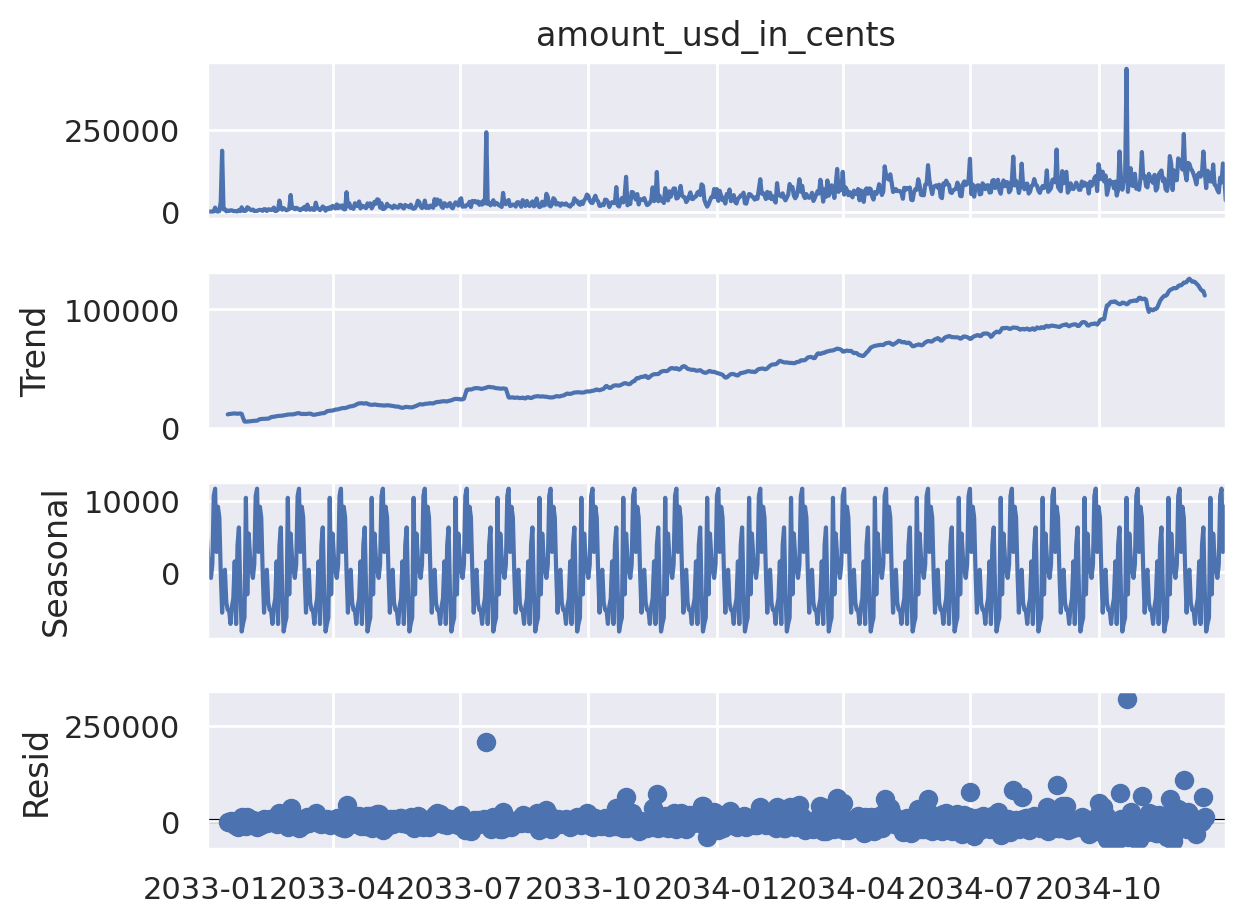

In [3]:
# Plot Trend and Data Seasonality
# Import extra libraries
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Holt Winters
# Single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponentiial smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = pd.read_csv('daily_transactions.csv', index_col = 'time', parse_dates=True)
decompose_result = seasonal_decompose(data['amount_usd_in_cents'],period=30) # Note: Data is in US Dollars not cents
decompose_result.plot(); # Plot Seasonality and Trend of Raw Data Only

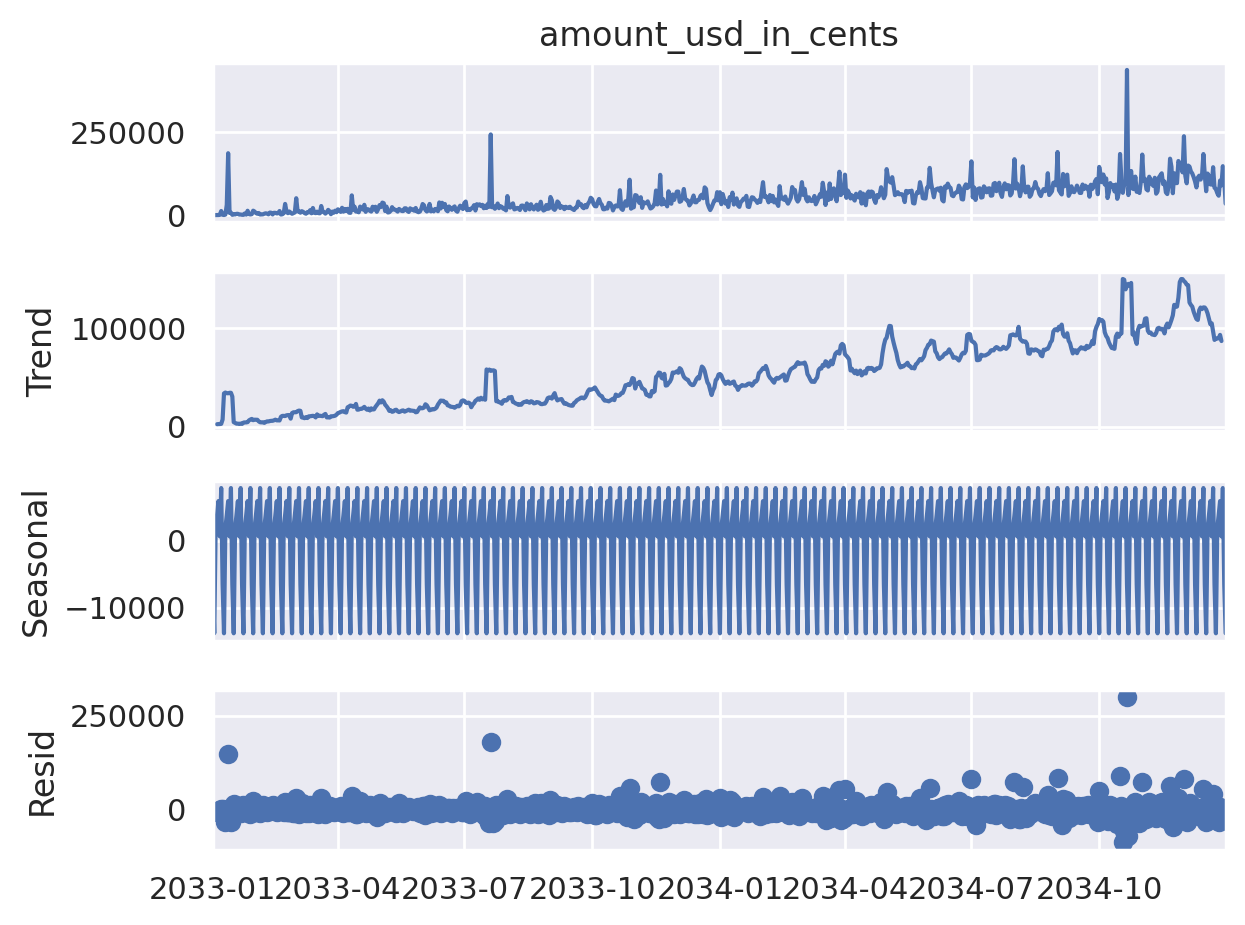

In [18]:
decompose_result = seasonal_decompose(data['amount_usd_in_cents'],period=7) # Note: Data is in US Dollars not cents
decompose_result.plot(); # Plot Seasonality and Trend of Raw Data Only

In [19]:
# Top plot is in US-Dollars not in cents
# Notice upward trend as well as the 30 days Seasonality, and 7 day Seasonality (second set of plots below)

In [ ]:
# Define function to Plot Moving Average Window

In [20]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

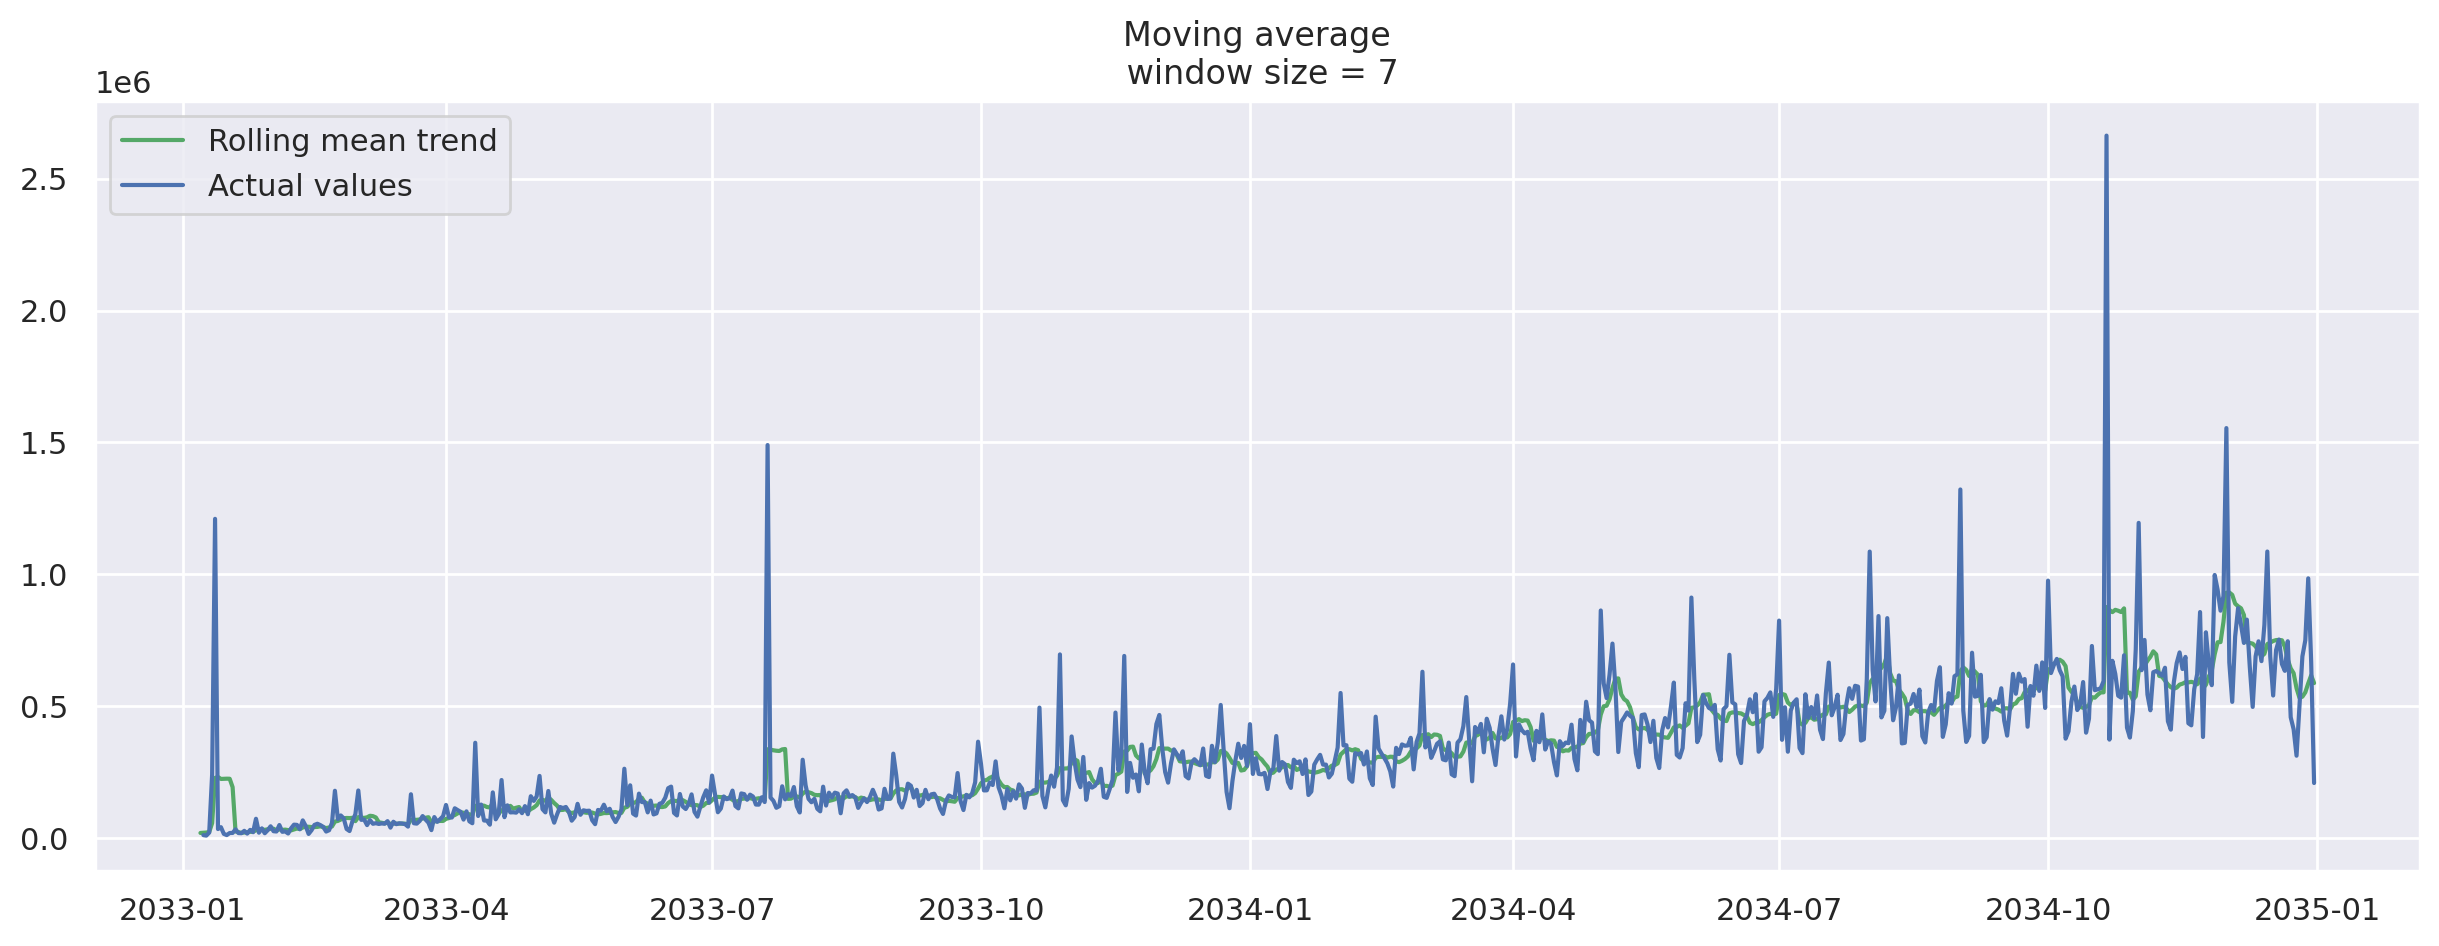

In [21]:
    Dollar_series = df.resample("D")["amount_usd_in_cents"].sum()/100
    plotMovingAverage(Dollar_series, 7) # Again, Y-axis in USD

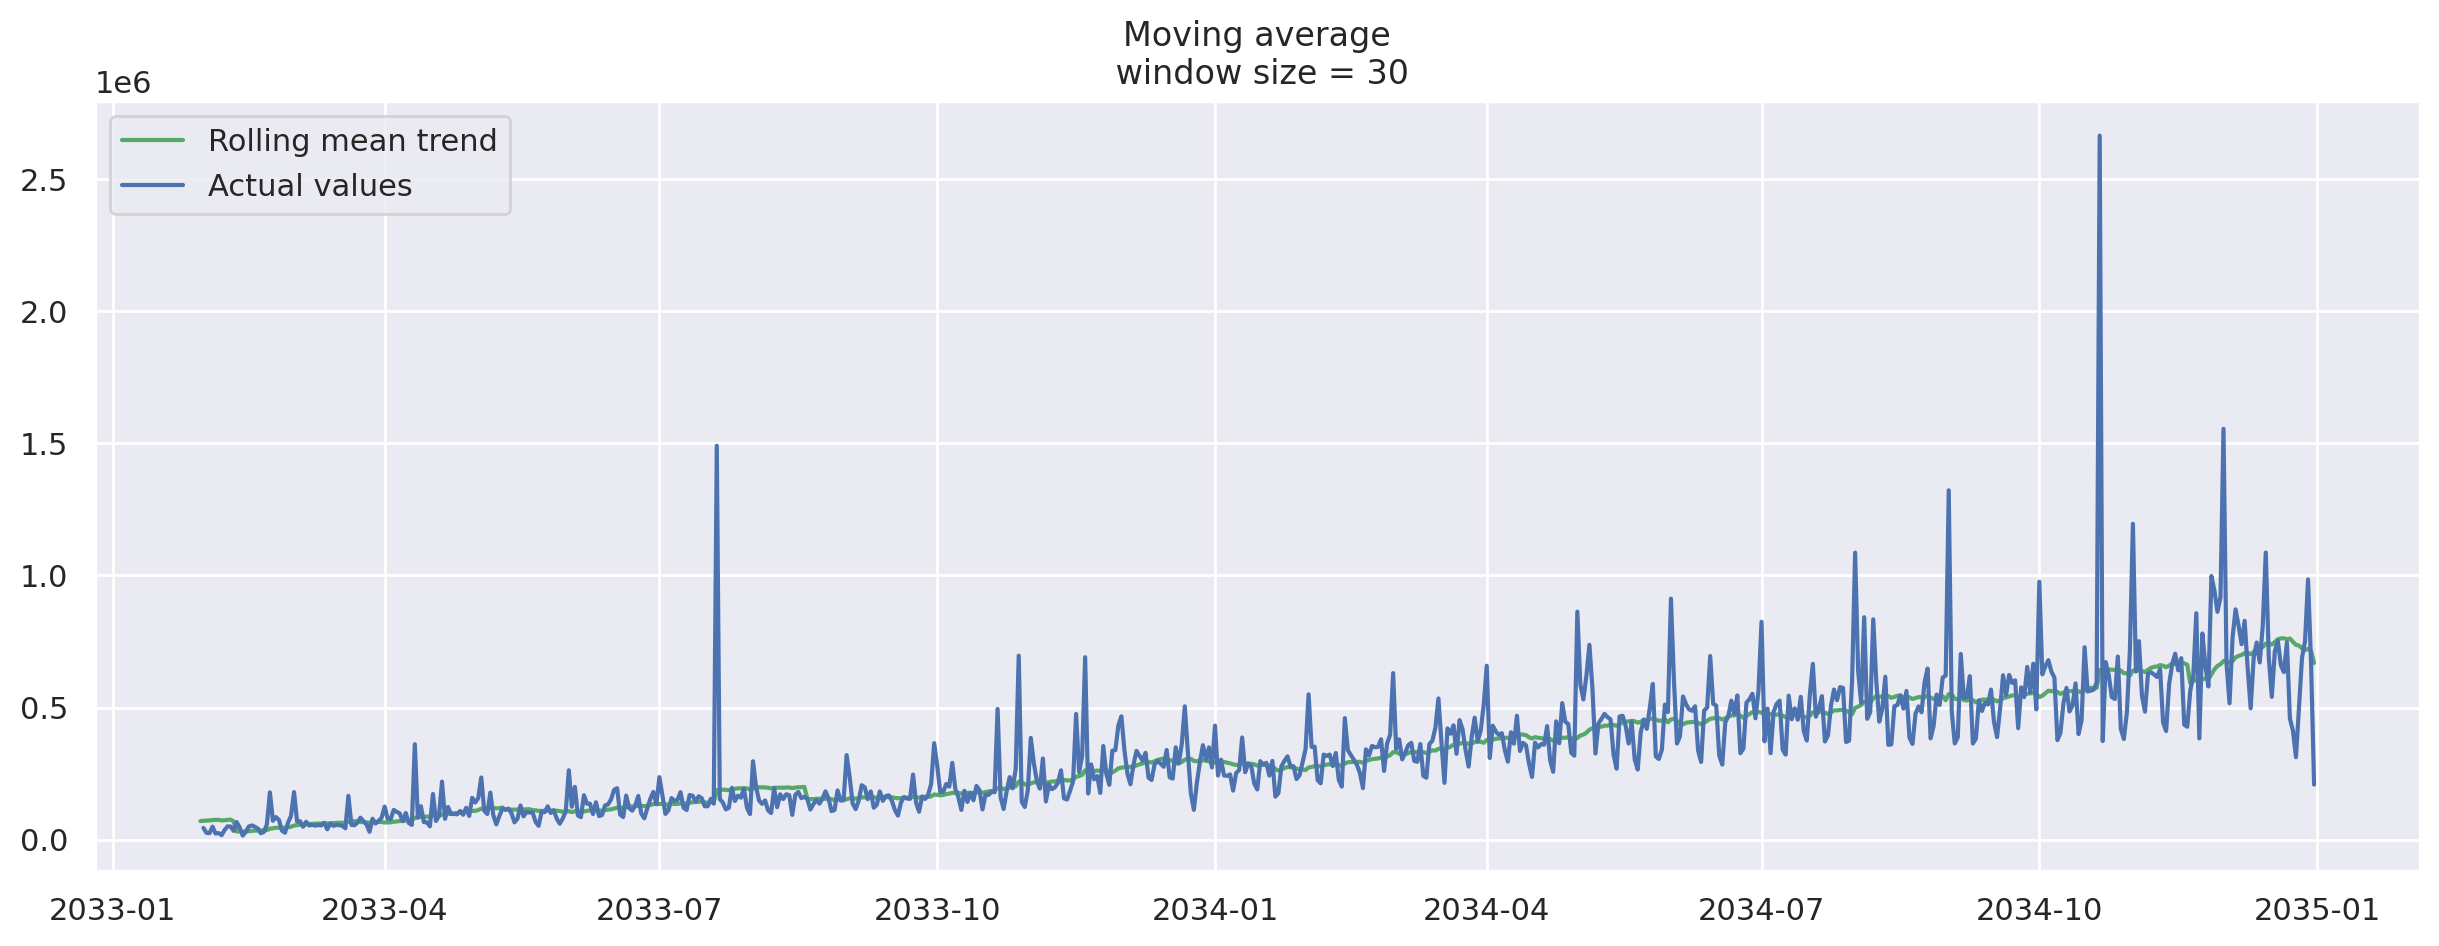

In [22]:

    plotMovingAverage(Dollar_series, 30) # 30-days moving average window

In [23]:
# Get Import Error Metrics

In [26]:
# Importing everything from above

from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [28]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [29]:
%%time
data = Dollar_series[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print("Alpha =",alpha_final,"Beta =", beta_final, "Gamma =",gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
print("Model Triple Expnentail Smoothing Paramenters (above):\n")
model.triple_exponential_smoothing()


Alpha = 0.008681677038578584 Beta = 0.026753637233499827 Gamma = 0.09102128155093181
Model Triple Expnentail Smoothing Paramenters (above):

CPU times: user 4.65 s, sys: 17.2 ms, total: 4.67 s
Wall time: 4.75 s


In [30]:
model.initial_seasonal_components()

{0: -29450.629597701136,
 1: -9831.733045977004,
 2: -27510.042356321836,
 3: -29563.939252873548,
 4: -11747.971666666659,
 5: 6966.334195402314,
 6: -5320.566839080447,
 7: -168.10718390803407,
 8: 51344.87385057472,
 9: -14909.127528735617,
 10: 92683.71454022989,
 11: 19770.95212643679,
 12: 36916.53626436784,
 13: -8748.350977011485,
 14: 60.9283333333462,
 15: -26334.068908045963,
 16: 2786.29729885059,
 17: -18636.24201149424,
 18: 3539.3128160919637,
 19: -22118.460632183895,
 20: 319.9466091954121,
 21: -3766.253045977001,
 22: -15467.241321839065,
 23: 9183.838333333357}

In [31]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    mse_hw = mean_squared_error(series.values, model.result[: len(series)])
    r2_hw = r2_score(series.values, model.result[: len(series)])
    print(f"Mean Squared Error (MSE): {mse_hw}")
    print(f"R-squared (R2): {r2_hw}")

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

Mean Squared Error (MSE): 20060832027.238697
R-squared (R2): 0.6717159537311732


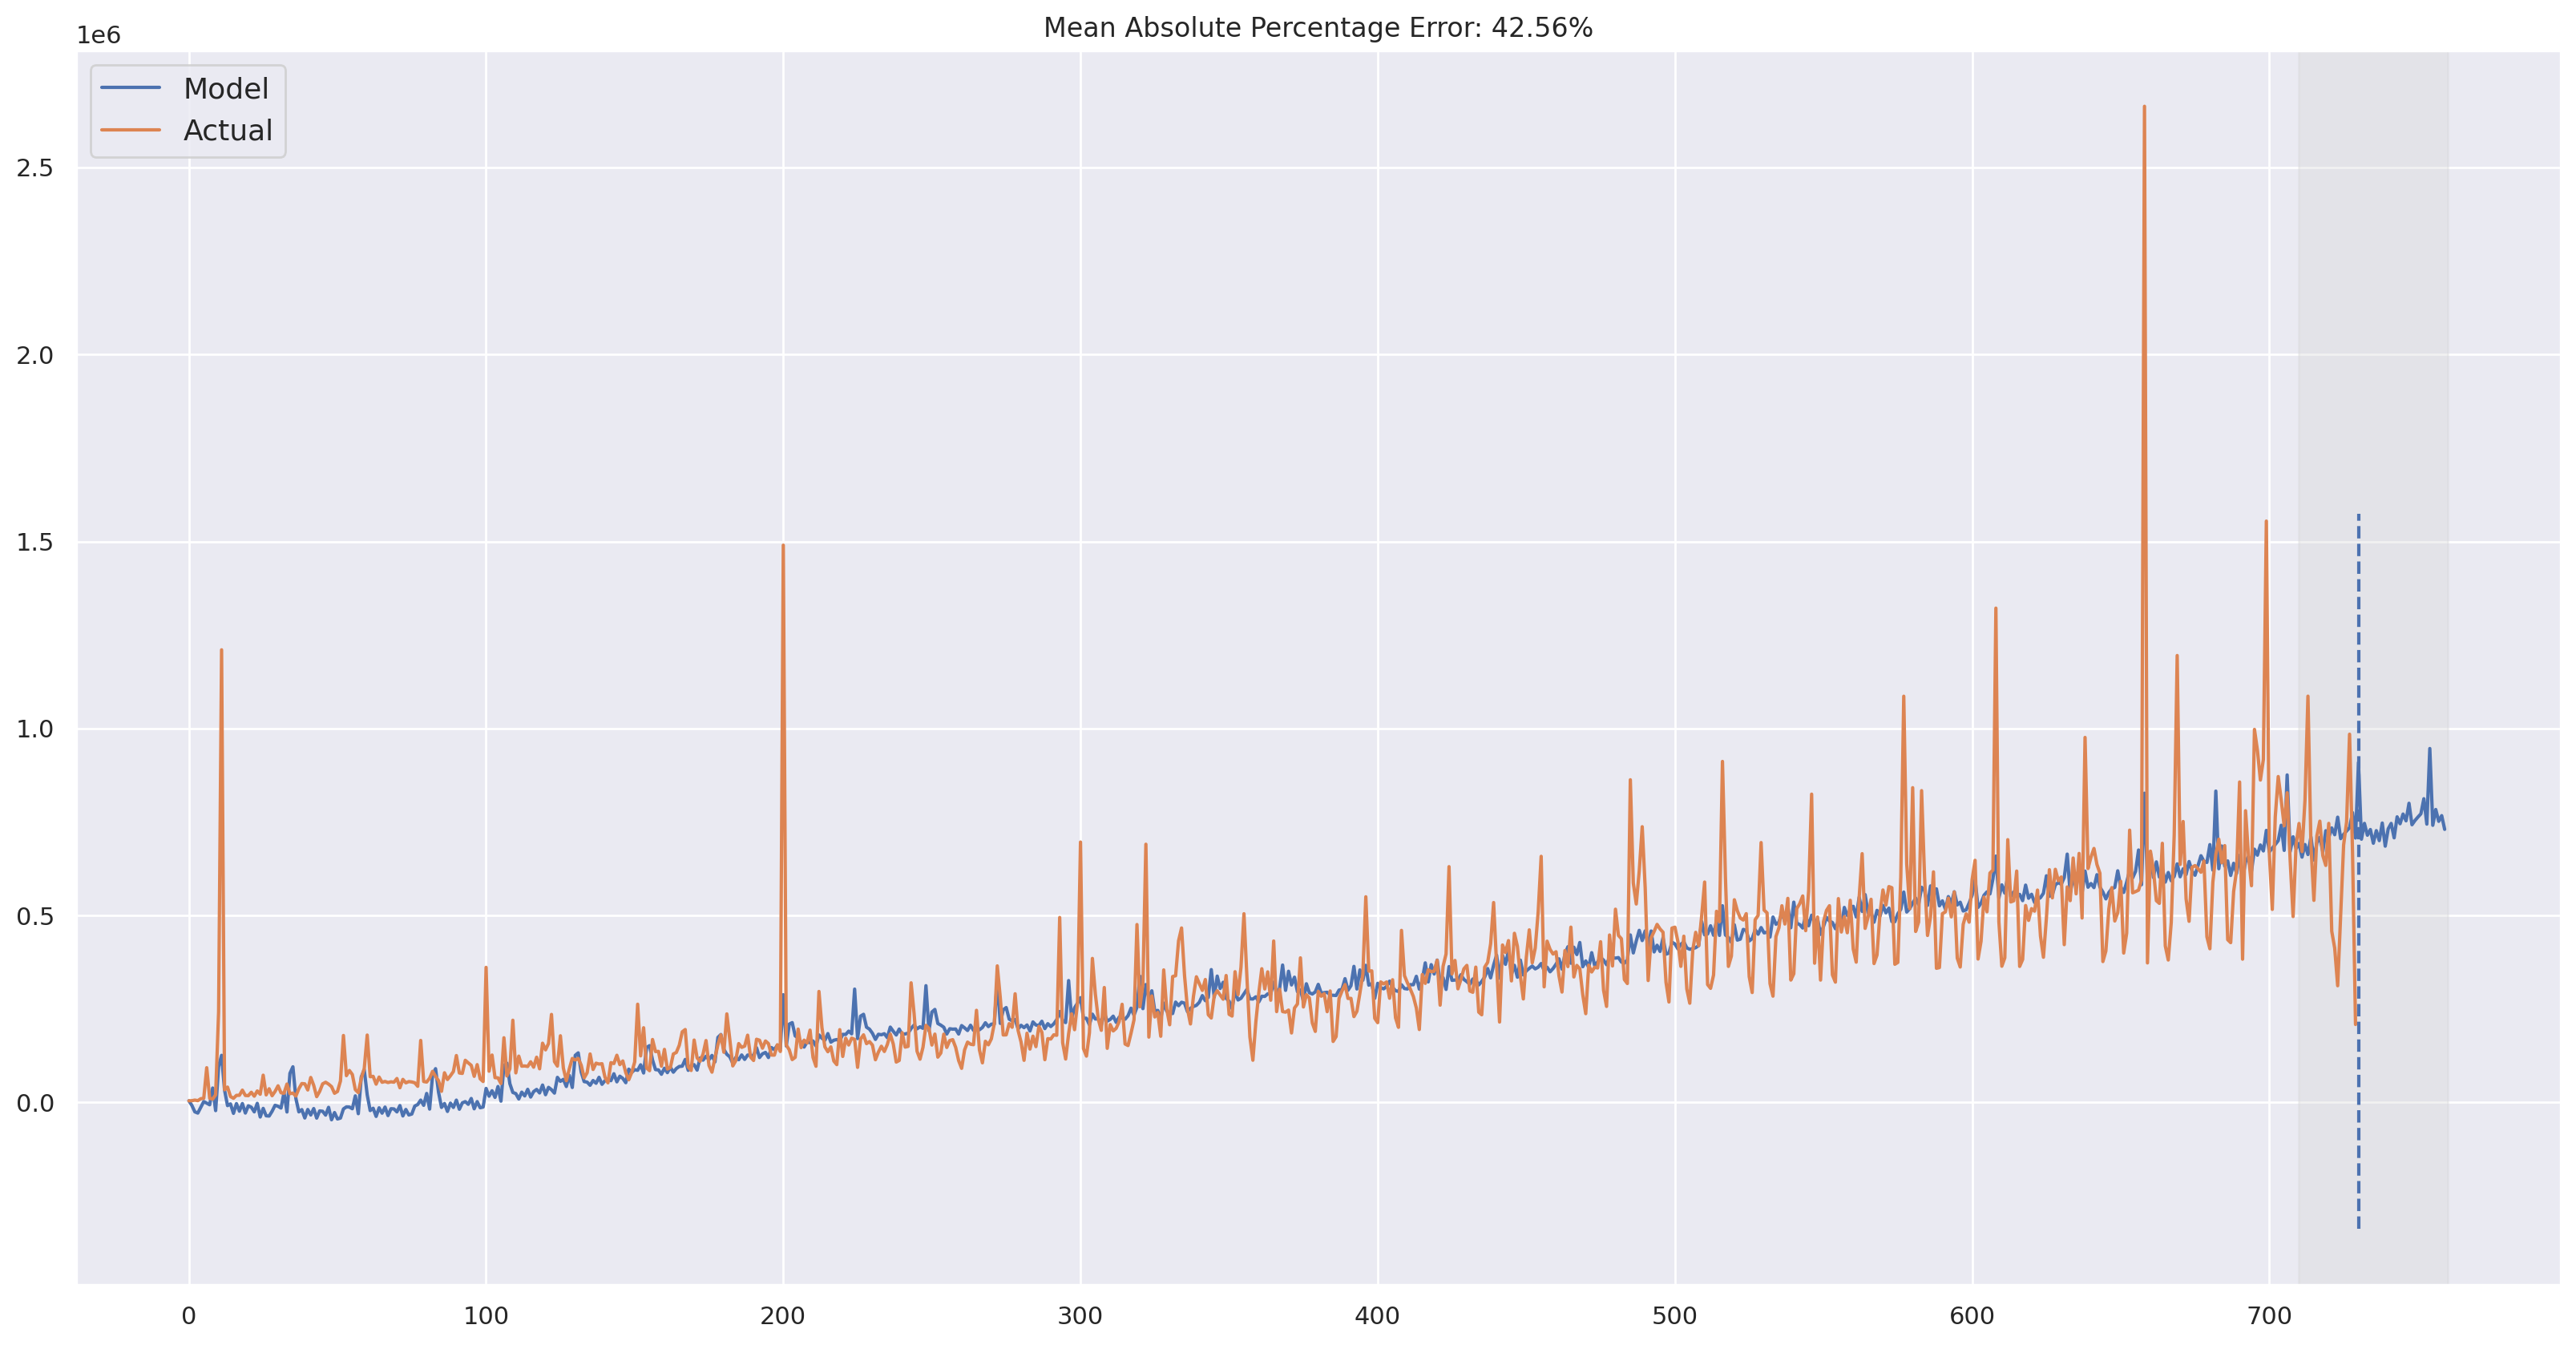

In [32]:
plotHoltWinters(Dollar_series)

Mean Squared Error (MSE): 20060832027.238697
R-squared (R2): 0.6717159537311732


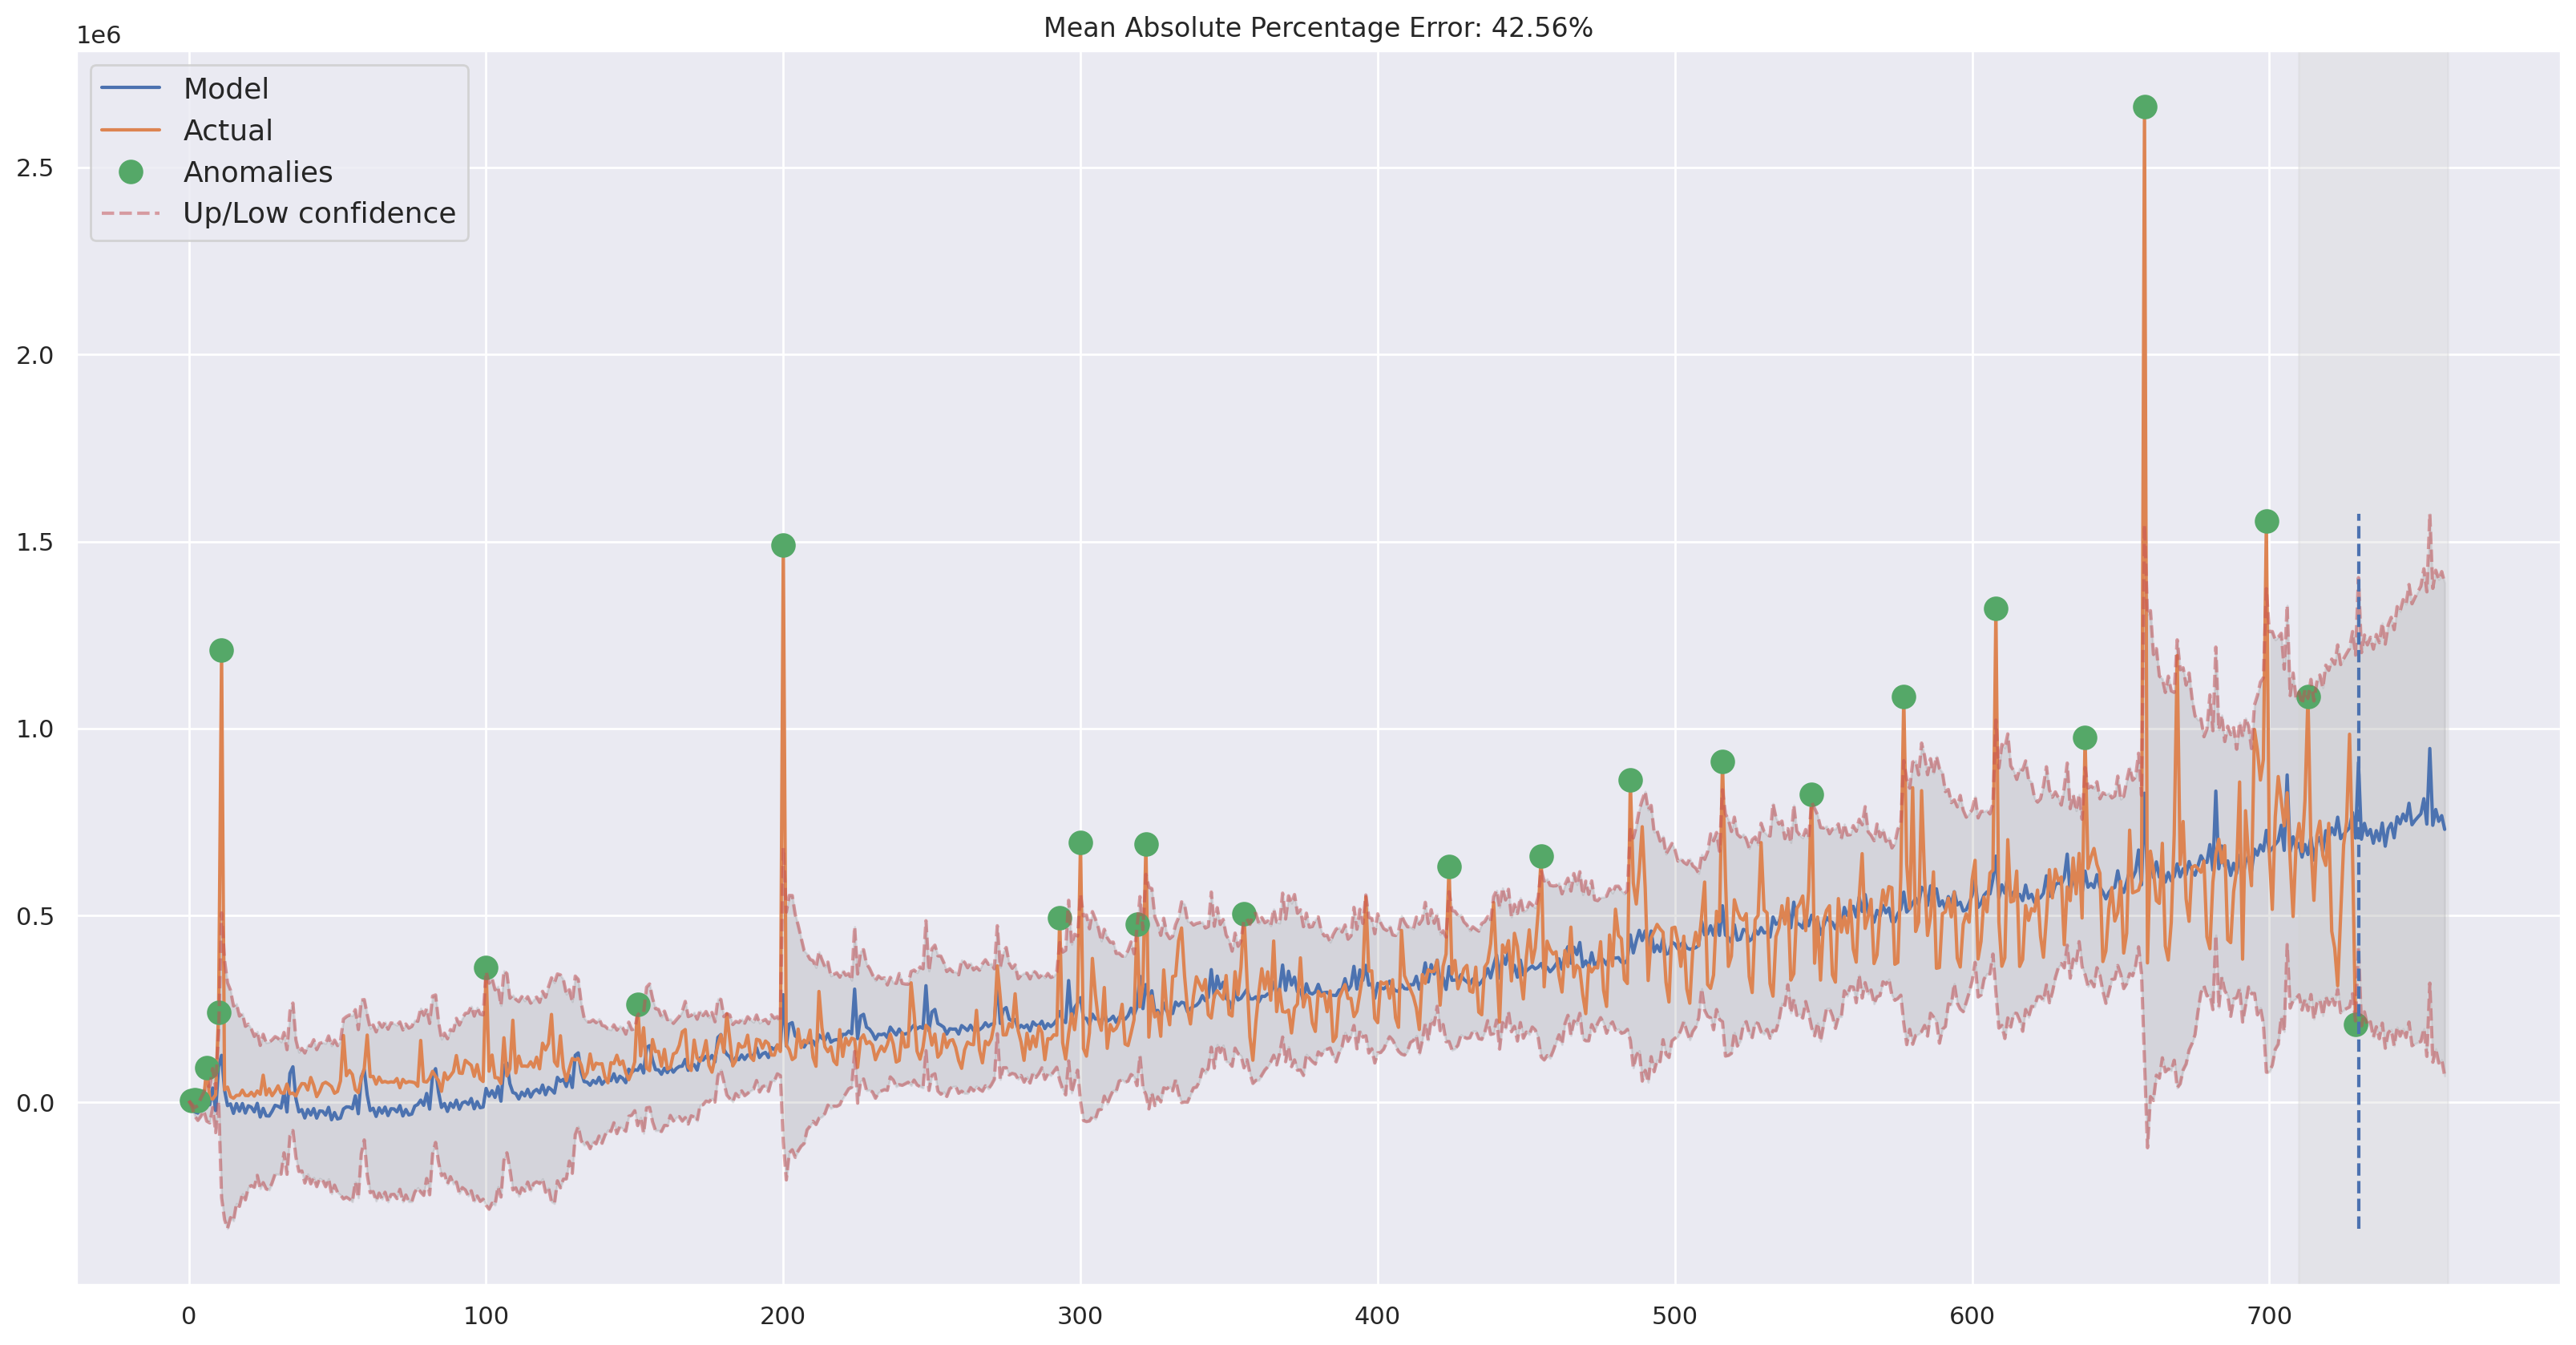

In [33]:
plotHoltWinters(Dollar_series, plot_intervals=True, plot_anomalies=True)

In [34]:
# Time Series Lags
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(Dollar_series.copy())
data.columns = ["y"]

In [35]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 24):
    data["lag_{}".format(i)] = data.y.shift(i)

In [38]:
# take a look at the new dataframe
data.head(25)

y       lag_6       lag_7       lag_8       lag_9  \
time                                                                     
2033-01-01     4415.40         NaN         NaN         NaN         NaN   
2033-01-02     4758.62         NaN         NaN         NaN         NaN   
2033-01-03     6283.53         NaN         NaN         NaN         NaN   
2033-01-04     4851.11         NaN         NaN         NaN         NaN   
2033-01-05    10016.21         NaN         NaN         NaN         NaN   
2033-01-06    11055.98         NaN         NaN         NaN         NaN   
2033-01-07    92925.77     4415.40         NaN         NaN         NaN   
2033-01-08    10977.77     4758.62     4415.40         NaN         NaN   
2033-01-09     9100.92     6283.53     4758.62     4415.40         NaN   
2033-01-10    20481.44     4851.11     6283.53     4758.62     4415.40   
2033-01-11   241898.77    10016.21     4851.11     6283.53     4758.62   
2033-01-12  1210293.14    11055.98    10016.21     4851.11     6283.53   
2033-01-13    34005.18    92925.77    11055.98    10016.21     4851.11   
2033-01-14    41119.03    10977.77    92925.77    11055.98    10016.21   
2033-01-15    15817.95     9100.92    10977.77    92925.77    11055.98   
2033-01-16    11087.61    20481.44     9100.92    10977.77    92925.77   
2033-01-17    18953.62   241898.77    20481.44     9100.92    10977.77   
2033-01-18    19194.69  1210293.14   241898.77    20481.44     9100.92   
2033-01-19    32943.04    34005.18  1210293.14   241898.77    20481.44   
2033-01-20    18733.76    41119.03    34005.18  1210293.14   241898.77   
2033-01-21    18221.52    15817.95    41119.03    34005.18  1210293.14   
2033-01-22    27234.13    11087.61    15817.95    41119.03    34005.18   
2033-01-23    16732.76    18953.62    11087.61    15817.95    41119.03   
2033-01-24    30777.09    19194.69    18953.62    11087.61    15817.95   
2033-01-25    21963.14    32943.04    19194.69    18953.62    11087.61   

                lag_10      lag_11      lag_12      lag_13     lag_14  \
time                                                                    
2033-01-01         NaN         NaN         NaN         NaN        NaN   
2033-01-02         NaN         NaN         NaN         NaN        NaN   
2033-01-03         NaN         NaN         NaN         NaN        NaN   
2033-01-04         NaN         NaN         NaN         NaN        NaN   
2033-01-05         NaN         NaN         NaN         NaN        NaN   
2033-01-06         NaN         NaN         NaN         NaN        NaN   
2033-01-07         NaN         NaN         NaN         NaN        NaN   
2033-01-08         NaN         NaN         NaN         NaN        NaN   
2033-01-09         NaN         NaN         NaN         NaN        NaN   
2033-01-10         NaN         NaN         NaN         NaN        NaN   
2033-01-11     4415.40         NaN         NaN         NaN        NaN   
2033-01-12     4758.62     4415.40         NaN         NaN        NaN   
2033-01-13     6283.53     4758.62     4415.40         NaN        NaN   
2033-01-14     4851.11     6283.53     4758.62     4415.40        NaN   
2033-01-15    10016.21     4851.11     6283.53     4758.62    4415.40   
2033-01-16    11055.98    10016.21     4851.11     6283.53    4758.62   
2033-01-17    92925.77    11055.98    10016.21     4851.11    6283.53   
2033-01-18    10977.77    92925.77    11055.98    10016.21    4851.11   
2033-01-19     9100.92    10977.77    92925.77    11055.98   10016.21   
2033-01-20    20481.44     9100.92    10977.77    92925.77   11055.98   
2033-01-21   241898.77    20481.44     9100.92    10977.77   92925.77   
2033-01-22  1210293.14   241898.77    20481.44     9100.92   10977.77   
2033-01-23    34005.18  1210293.14   241898.77    20481.44    9100.92   
2033-01-24    41119.03    34005.18  1210293.14   241898.77   20481.44   
2033-01-25    15817.95    41119.03    34005.18  1210293.14  241898.77   

              lag_15    lag_16    lag_17    lag_18

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2033-01-01 to 2034-12-31
Freq: D
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       730 non-null    float64
 1   lag_6   724 non-null    float64
 2   lag_7   723 non-null    float64
 3   lag_8   722 non-null    float64
 4   lag_9   721 non-null    float64
 5   lag_10  720 non-null    float64
 6   lag_11  719 non-null    float64
 7   lag_12  718 non-null    float64
 8   lag_13  717 non-null    float64
 9   lag_14  716 non-null    float64
 10  lag_15  715 non-null    float64
 11  lag_16  714 non-null    float64
 12  lag_17  713 non-null    float64
 13  lag_18  712 non-null    float64
 14  lag_19  711 non-null    float64
 15  lag_20  710 non-null    float64
 16  lag_21  709 non-null    float64
 17  lag_22  708 non-null    float64
 18  lag_23  707 non-null    float64
dtypes: float64(19)
memory usage: 114.1 KB


In [40]:
# Train New Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [43]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [44]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [45]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [46]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    print('MAPE = ', error)
    mse_lr = mean_squared_error(y_test,prediction)
    r2_lr = r2_score(y_test,prediction)
    print(f"Mean Squared Error (MSE): {mse_lr}")
    print(f"R-squared (R2): {r2_lr}")
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

MAPE =  21.210589620587104
Mean Squared Error (MSE): 50488494155.68192
R-squared (R2): 0.03308895153644298


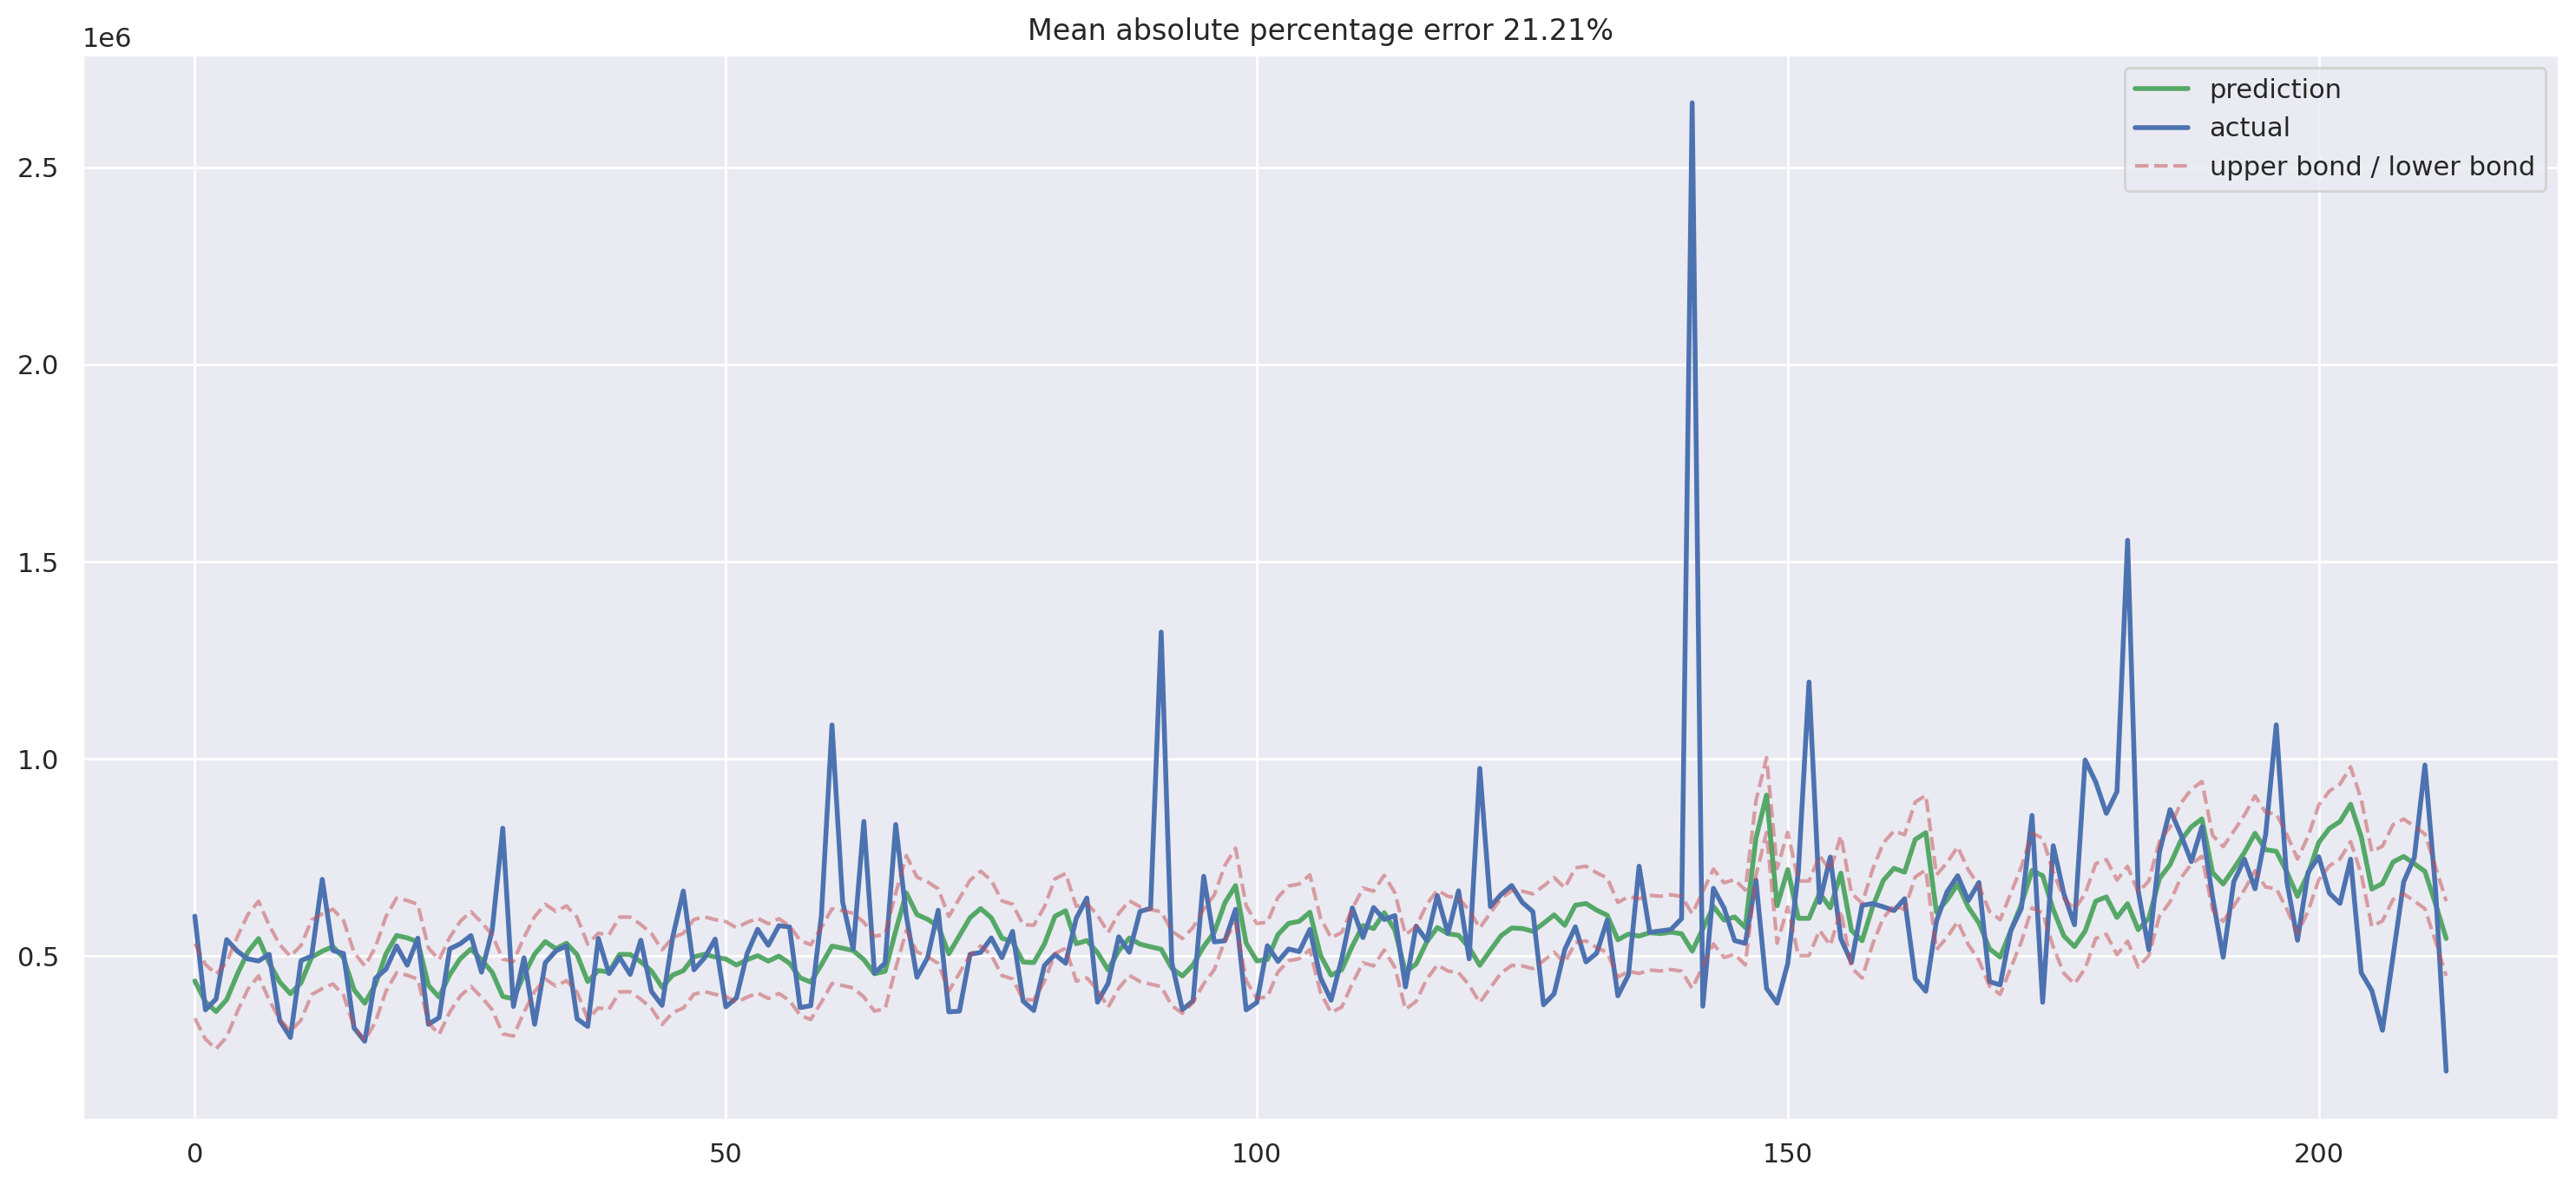

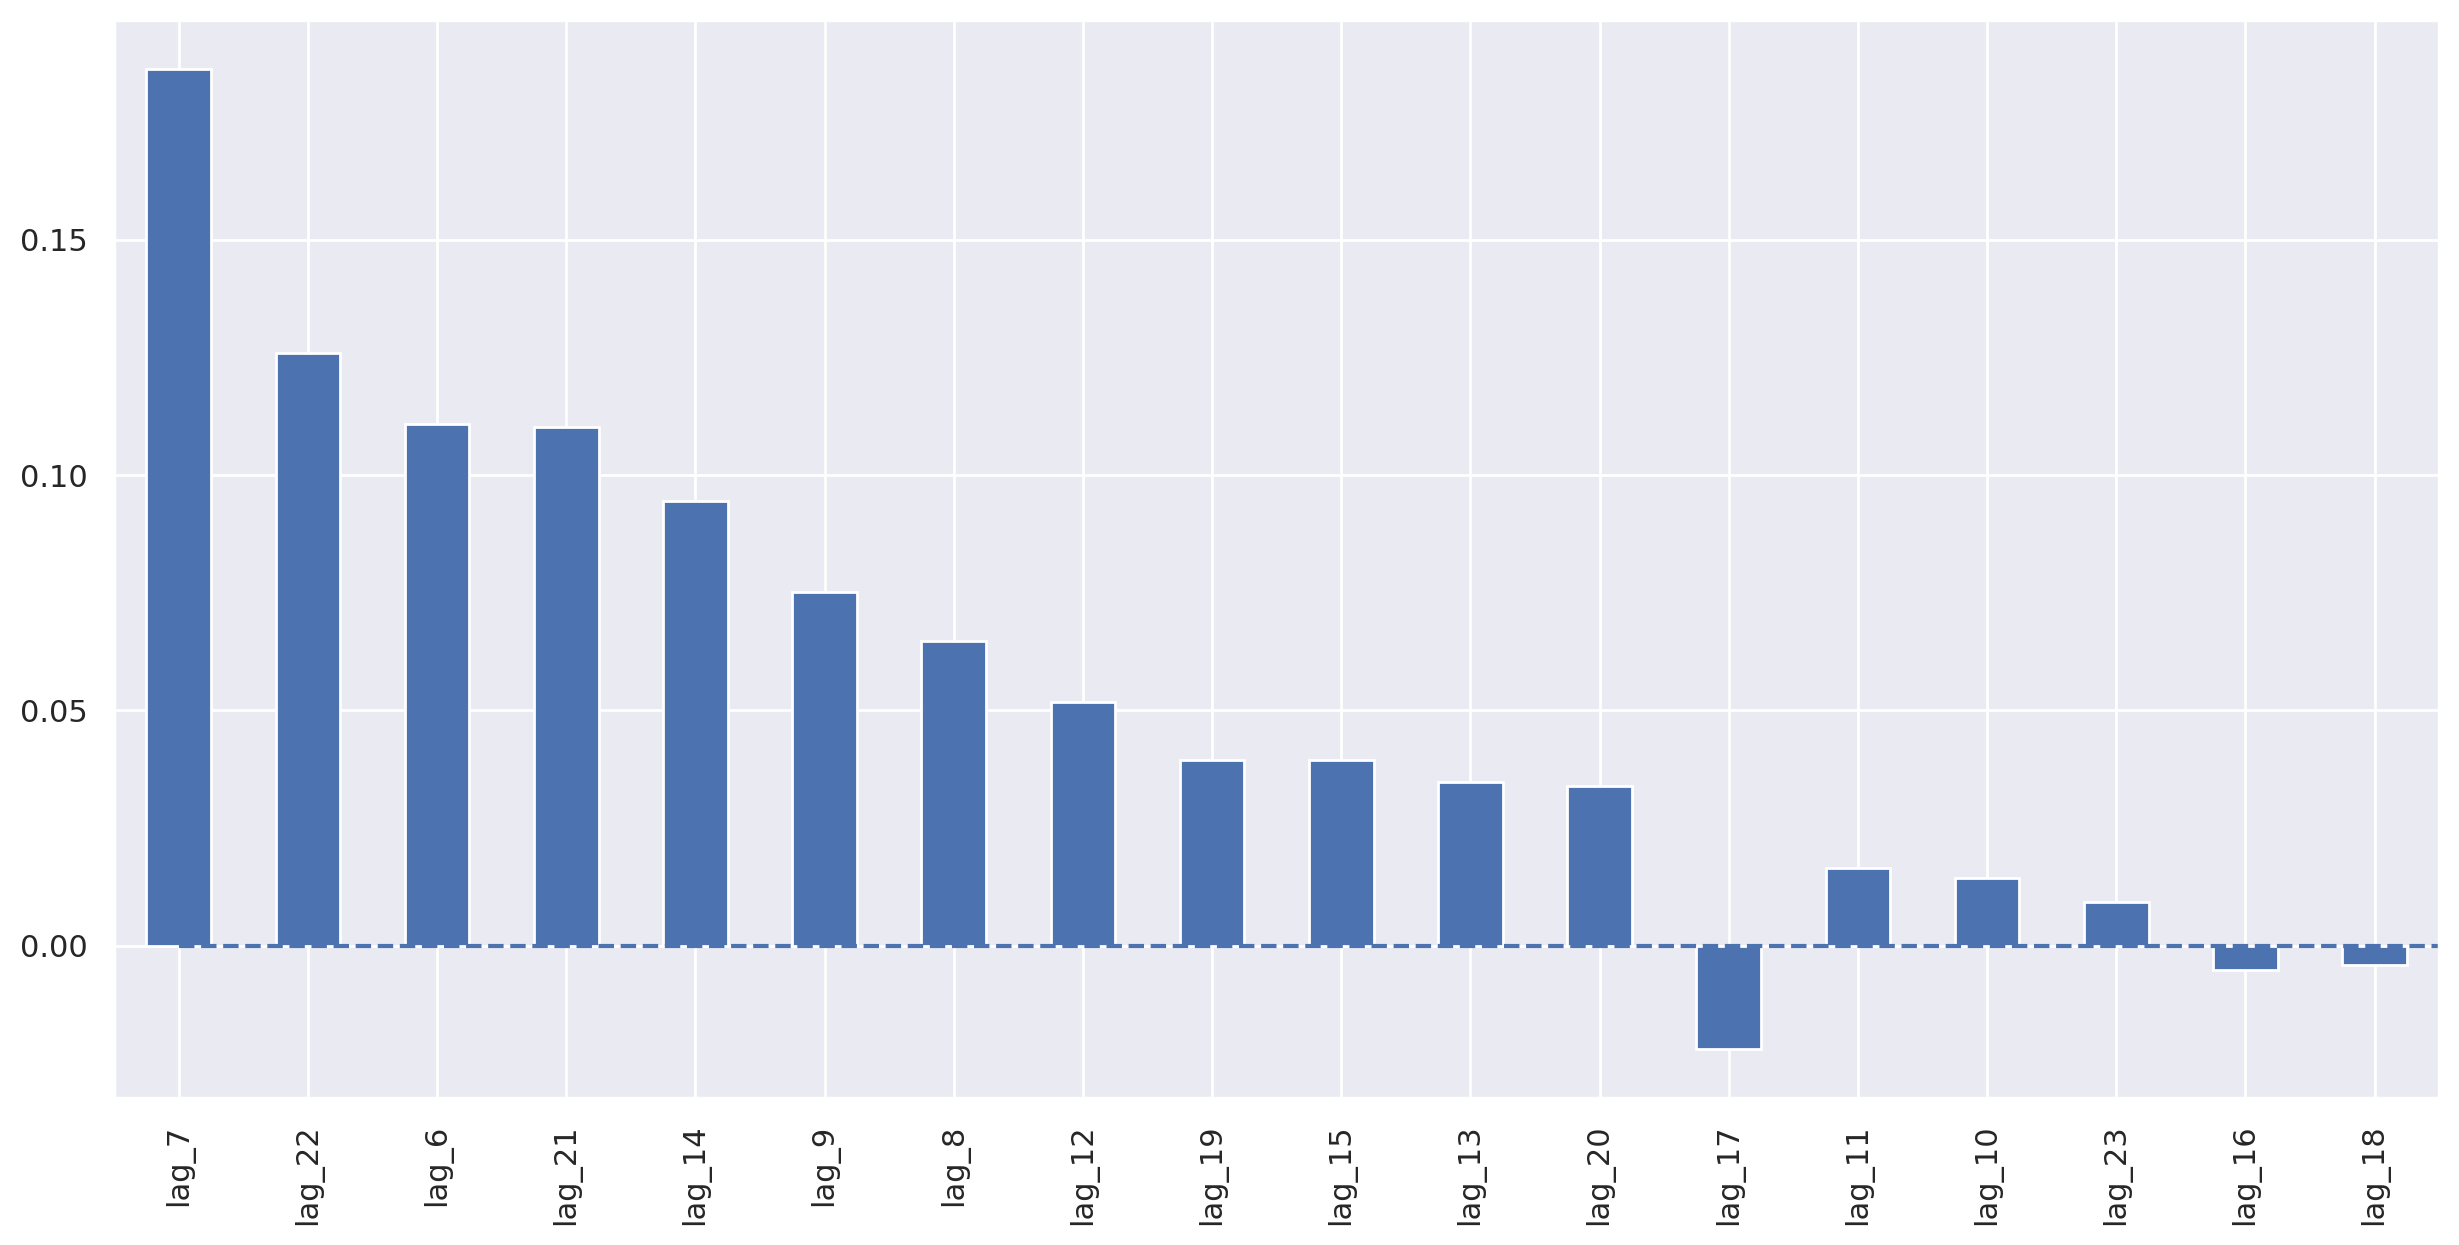

In [47]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [48]:
# Scale Feature Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [67]:
data.head(5)

y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  \
time                                                                       
2033-01-01   4415.40    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2033-01-02   4758.62    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2033-01-03   6283.53    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2033-01-04   4851.11    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2033-01-05  10016.21    NaN    NaN    NaN    NaN     NaN     NaN     NaN   

            lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  lag_19  lag_20  \
time                                                                         
2033-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2033-01-02     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2033-01-03     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2033-01-04     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2033-01-05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            lag_21  lag_22  lag_23  
time                                
2033-01-01     NaN     NaN     NaN  
2033-01-02     NaN     NaN     NaN  
2033-01-03     NaN     NaN     NaN  
2033-01-04     NaN     NaN     NaN  
2033-01-05     NaN     NaN     NaN

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2033-01-01 to 2034-12-31
Freq: D
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       730 non-null    float64
 1   lag_6   724 non-null    float64
 2   lag_7   723 non-null    float64
 3   lag_8   722 non-null    float64
 4   lag_9   721 non-null    float64
 5   lag_10  720 non-null    float64
 6   lag_11  719 non-null    float64
 7   lag_12  718 non-null    float64
 8   lag_13  717 non-null    float64
 9   lag_14  716 non-null    float64
 10  lag_15  715 non-null    float64
 11  lag_16  714 non-null    float64
 12  lag_17  713 non-null    float64
 13  lag_18  712 non-null    float64
 14  lag_19  711 non-null    float64
 15  lag_20  710 non-null    float64
 16  lag_21  709 non-null    float64
 17  lag_22  708 non-null    float64
 18  lag_23  707 non-null    float64
dtypes: float64(19)
memory usage: 114.1 KB


MAPE =  21.2105896205871
Mean Squared Error (MSE): 50488494155.68193
R-squared (R2): 0.03308895153644276


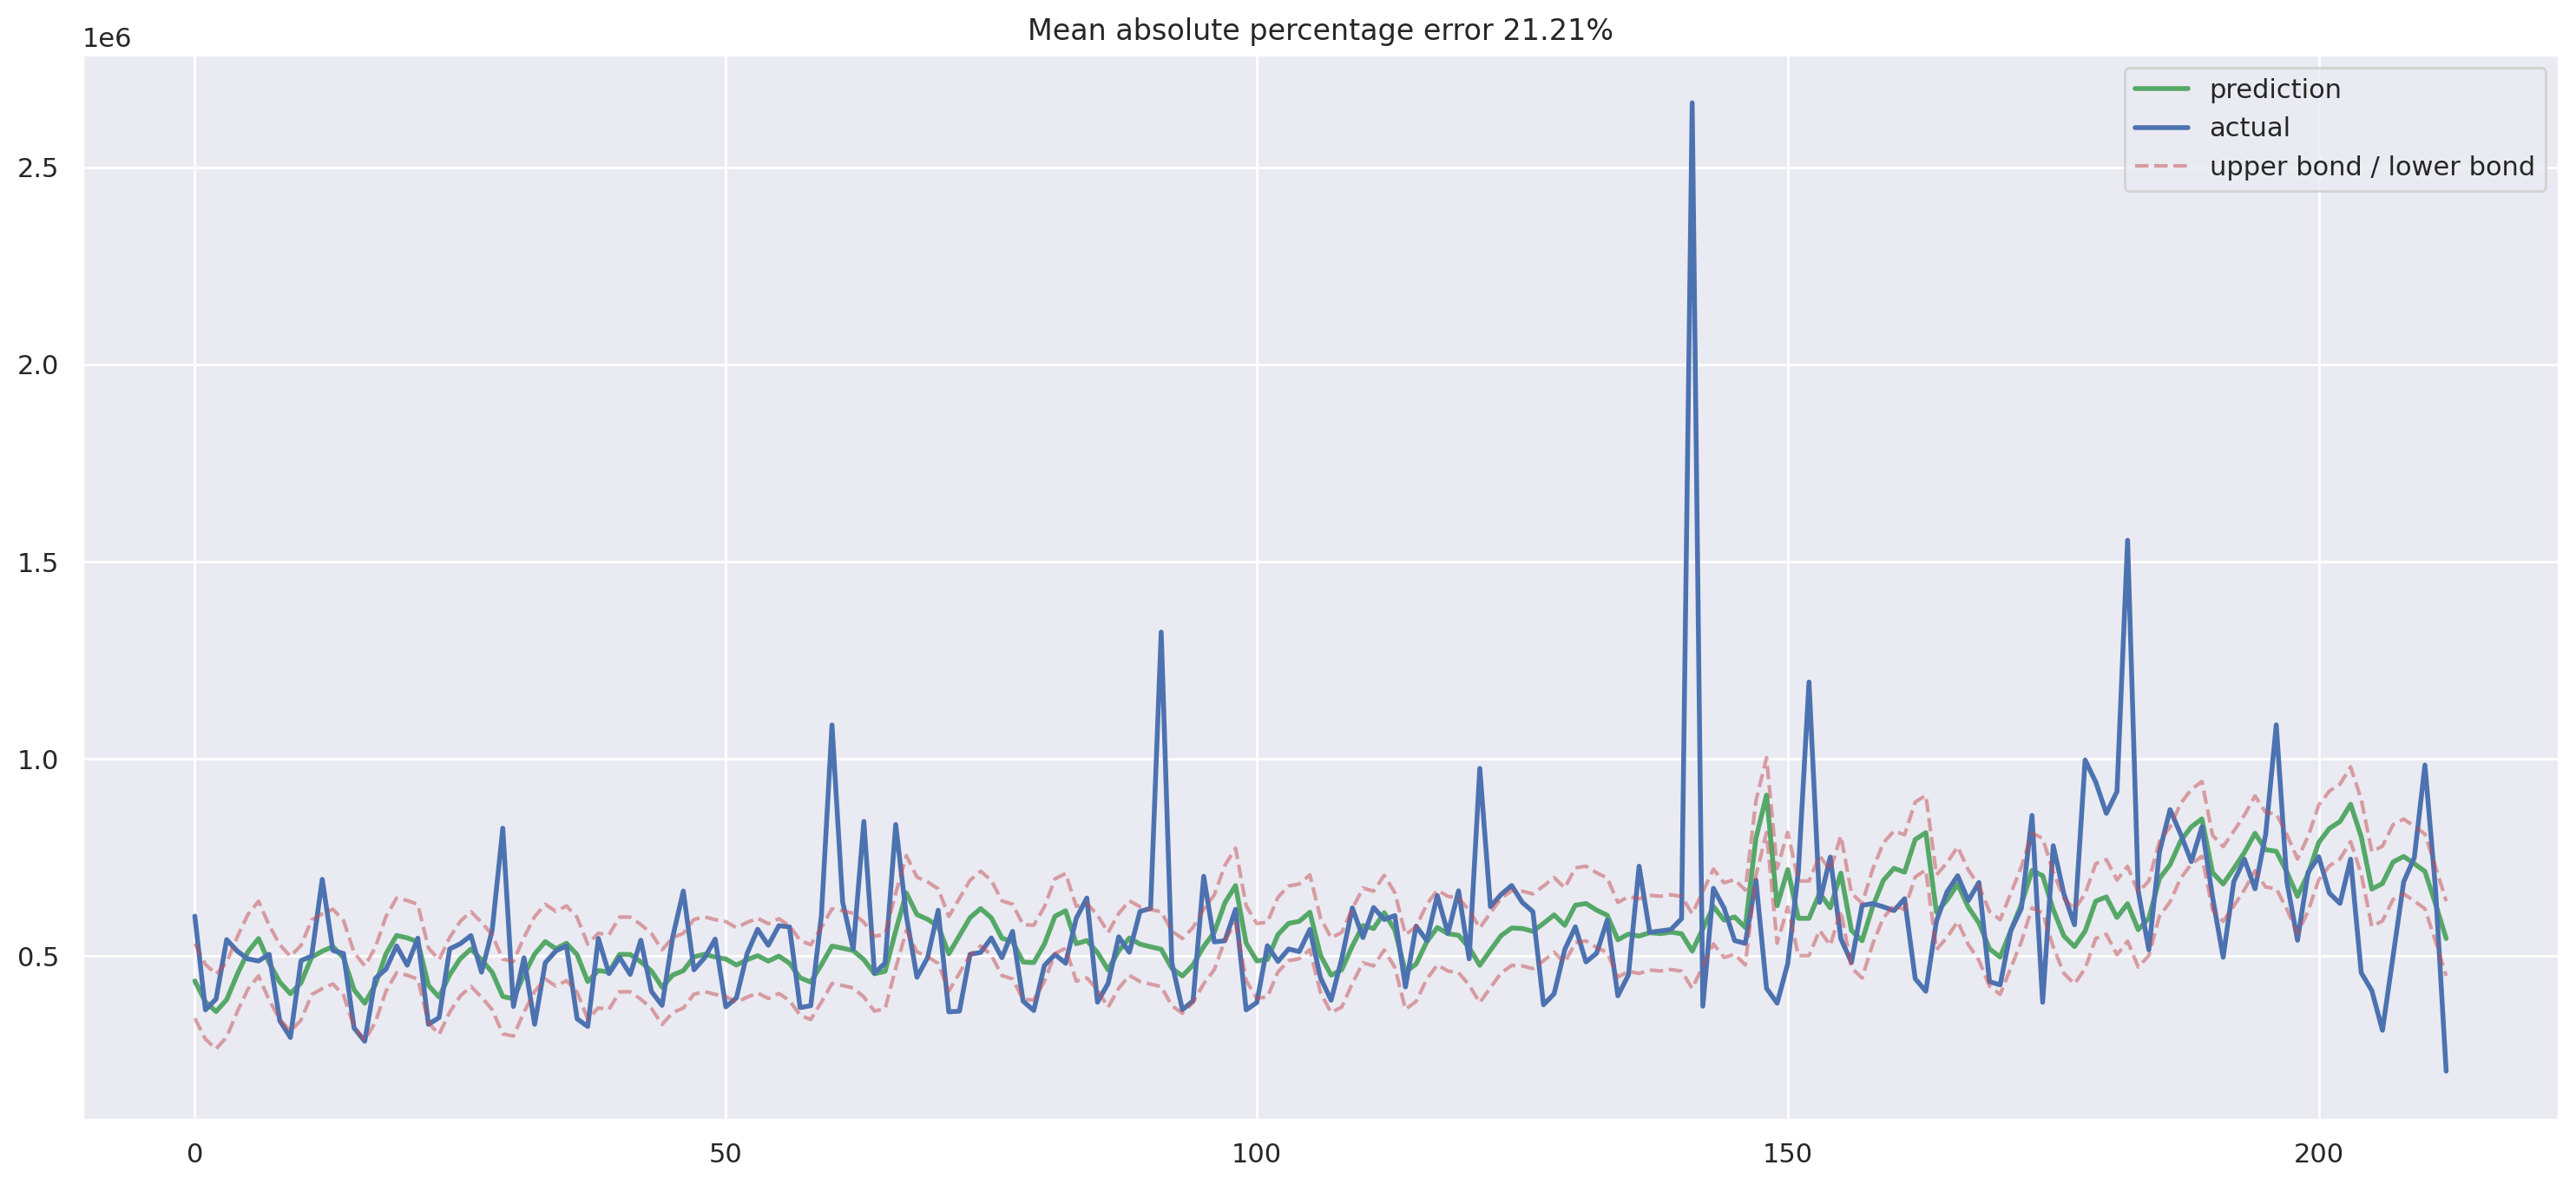

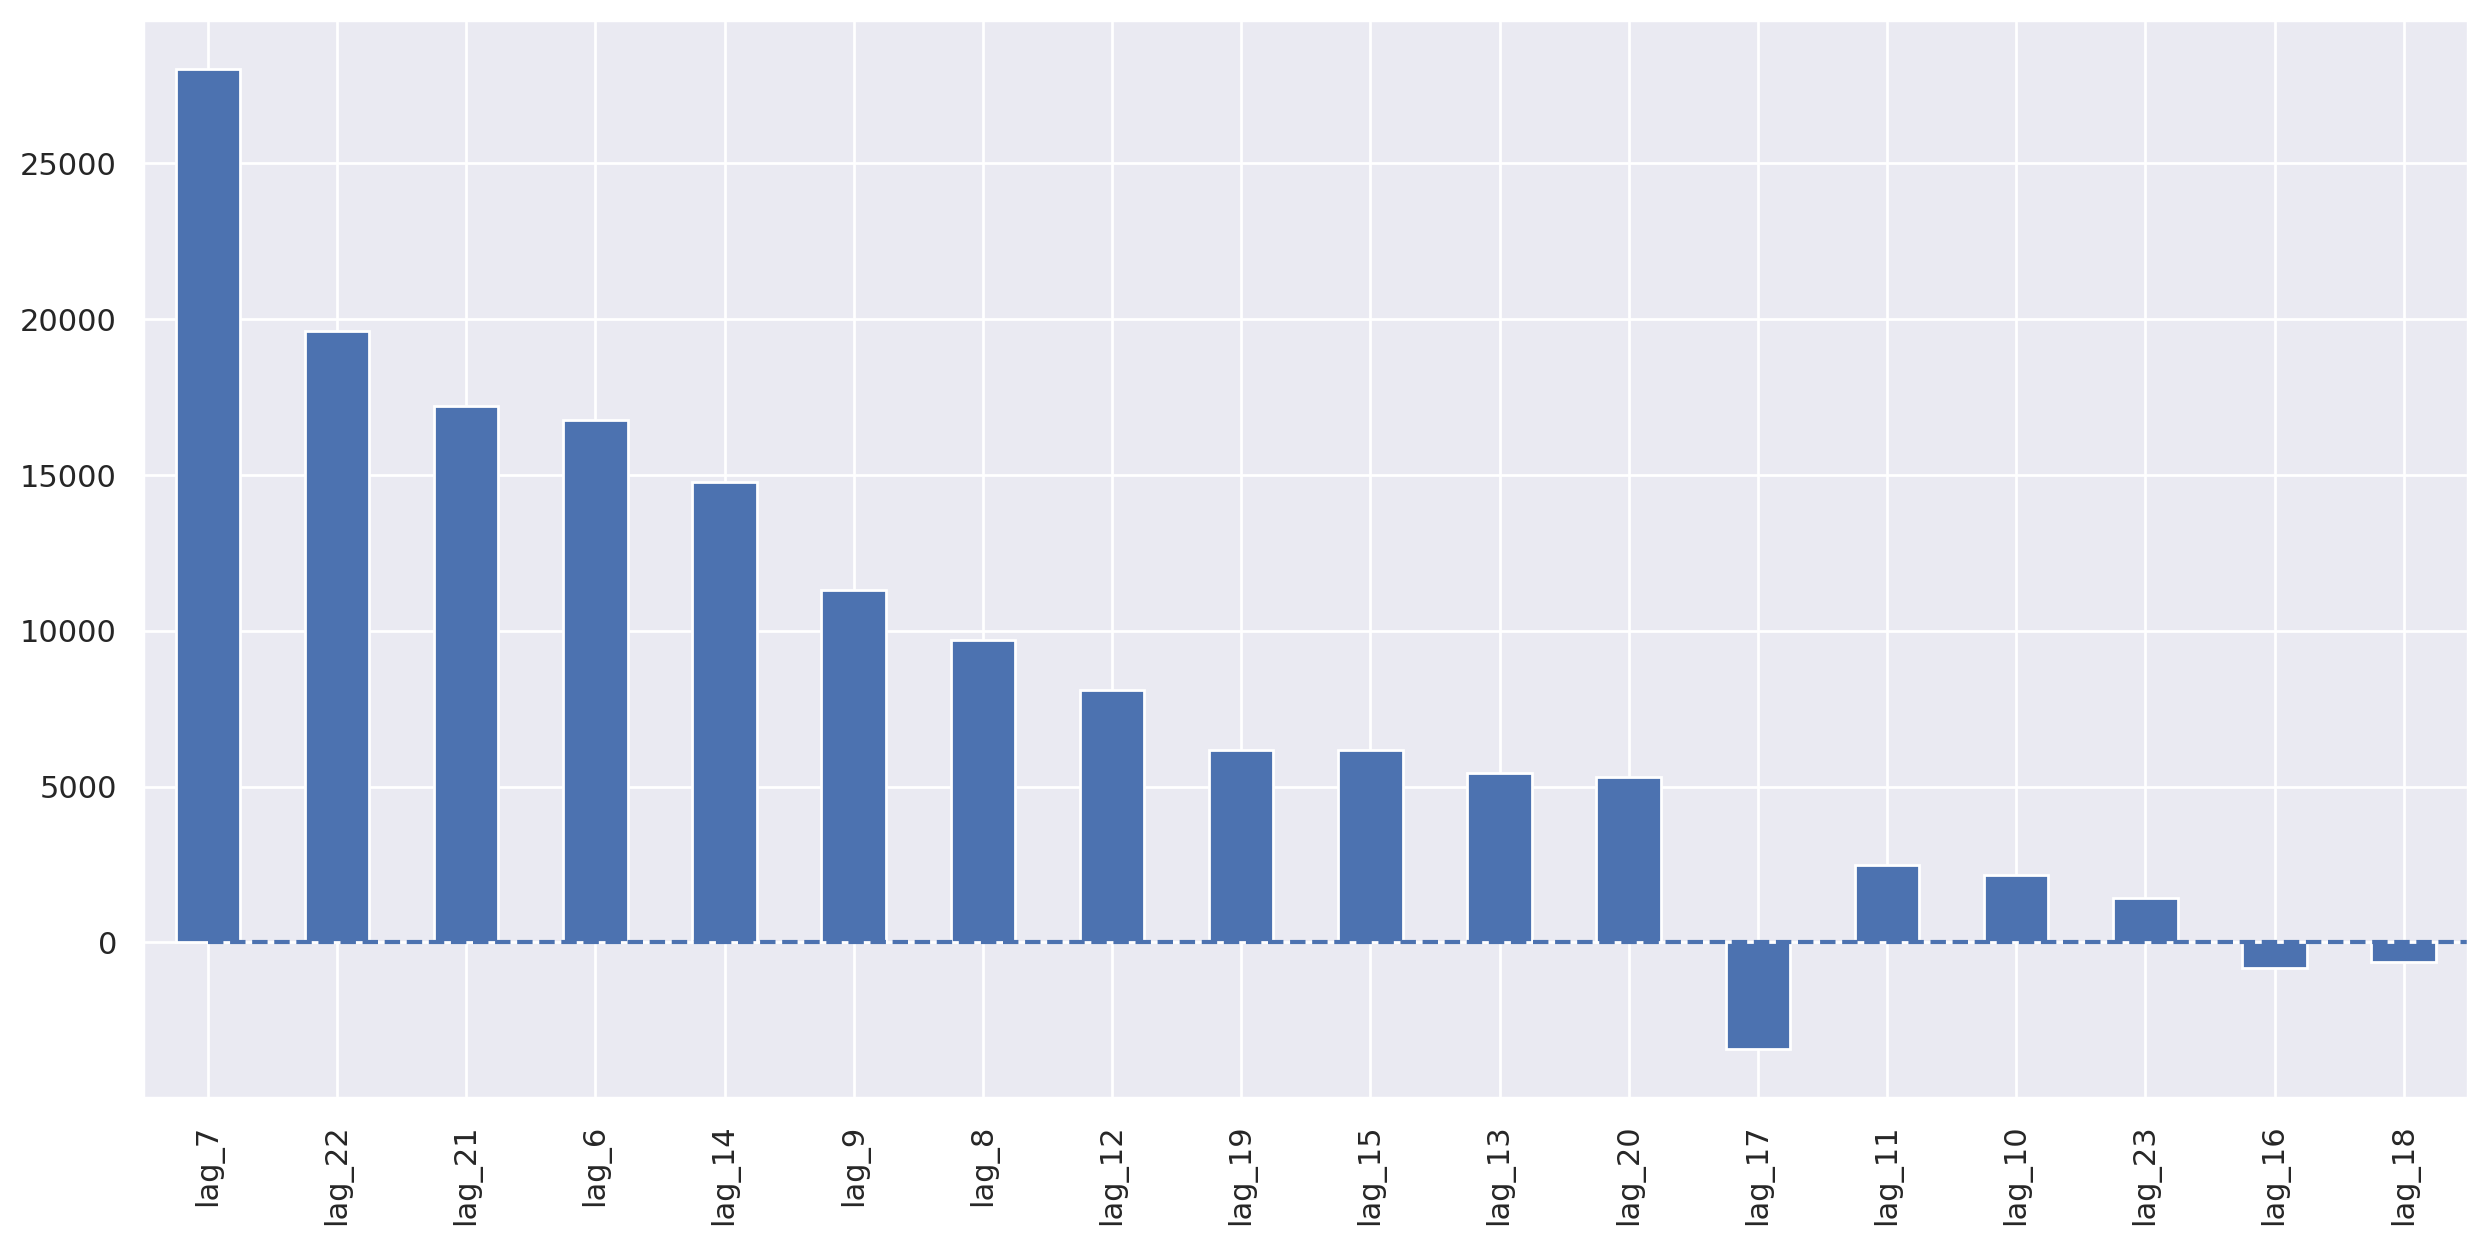

In [50]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [51]:
#Target Encoding
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [53]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset

    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data["weekday_average"] = list(
            map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
        )
        data["hour_average"] = list(
            map(code_mean(data[:test_index], "hour", "y").get, data.hour)
        )

        # drop encoded variables
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size
    )

    return X_train, X_test, y_train, y_test

MAPE =  20.0473328863316
Mean Squared Error (MSE): 48693985629.86982
R-squared (R2): 0.07178968842218436


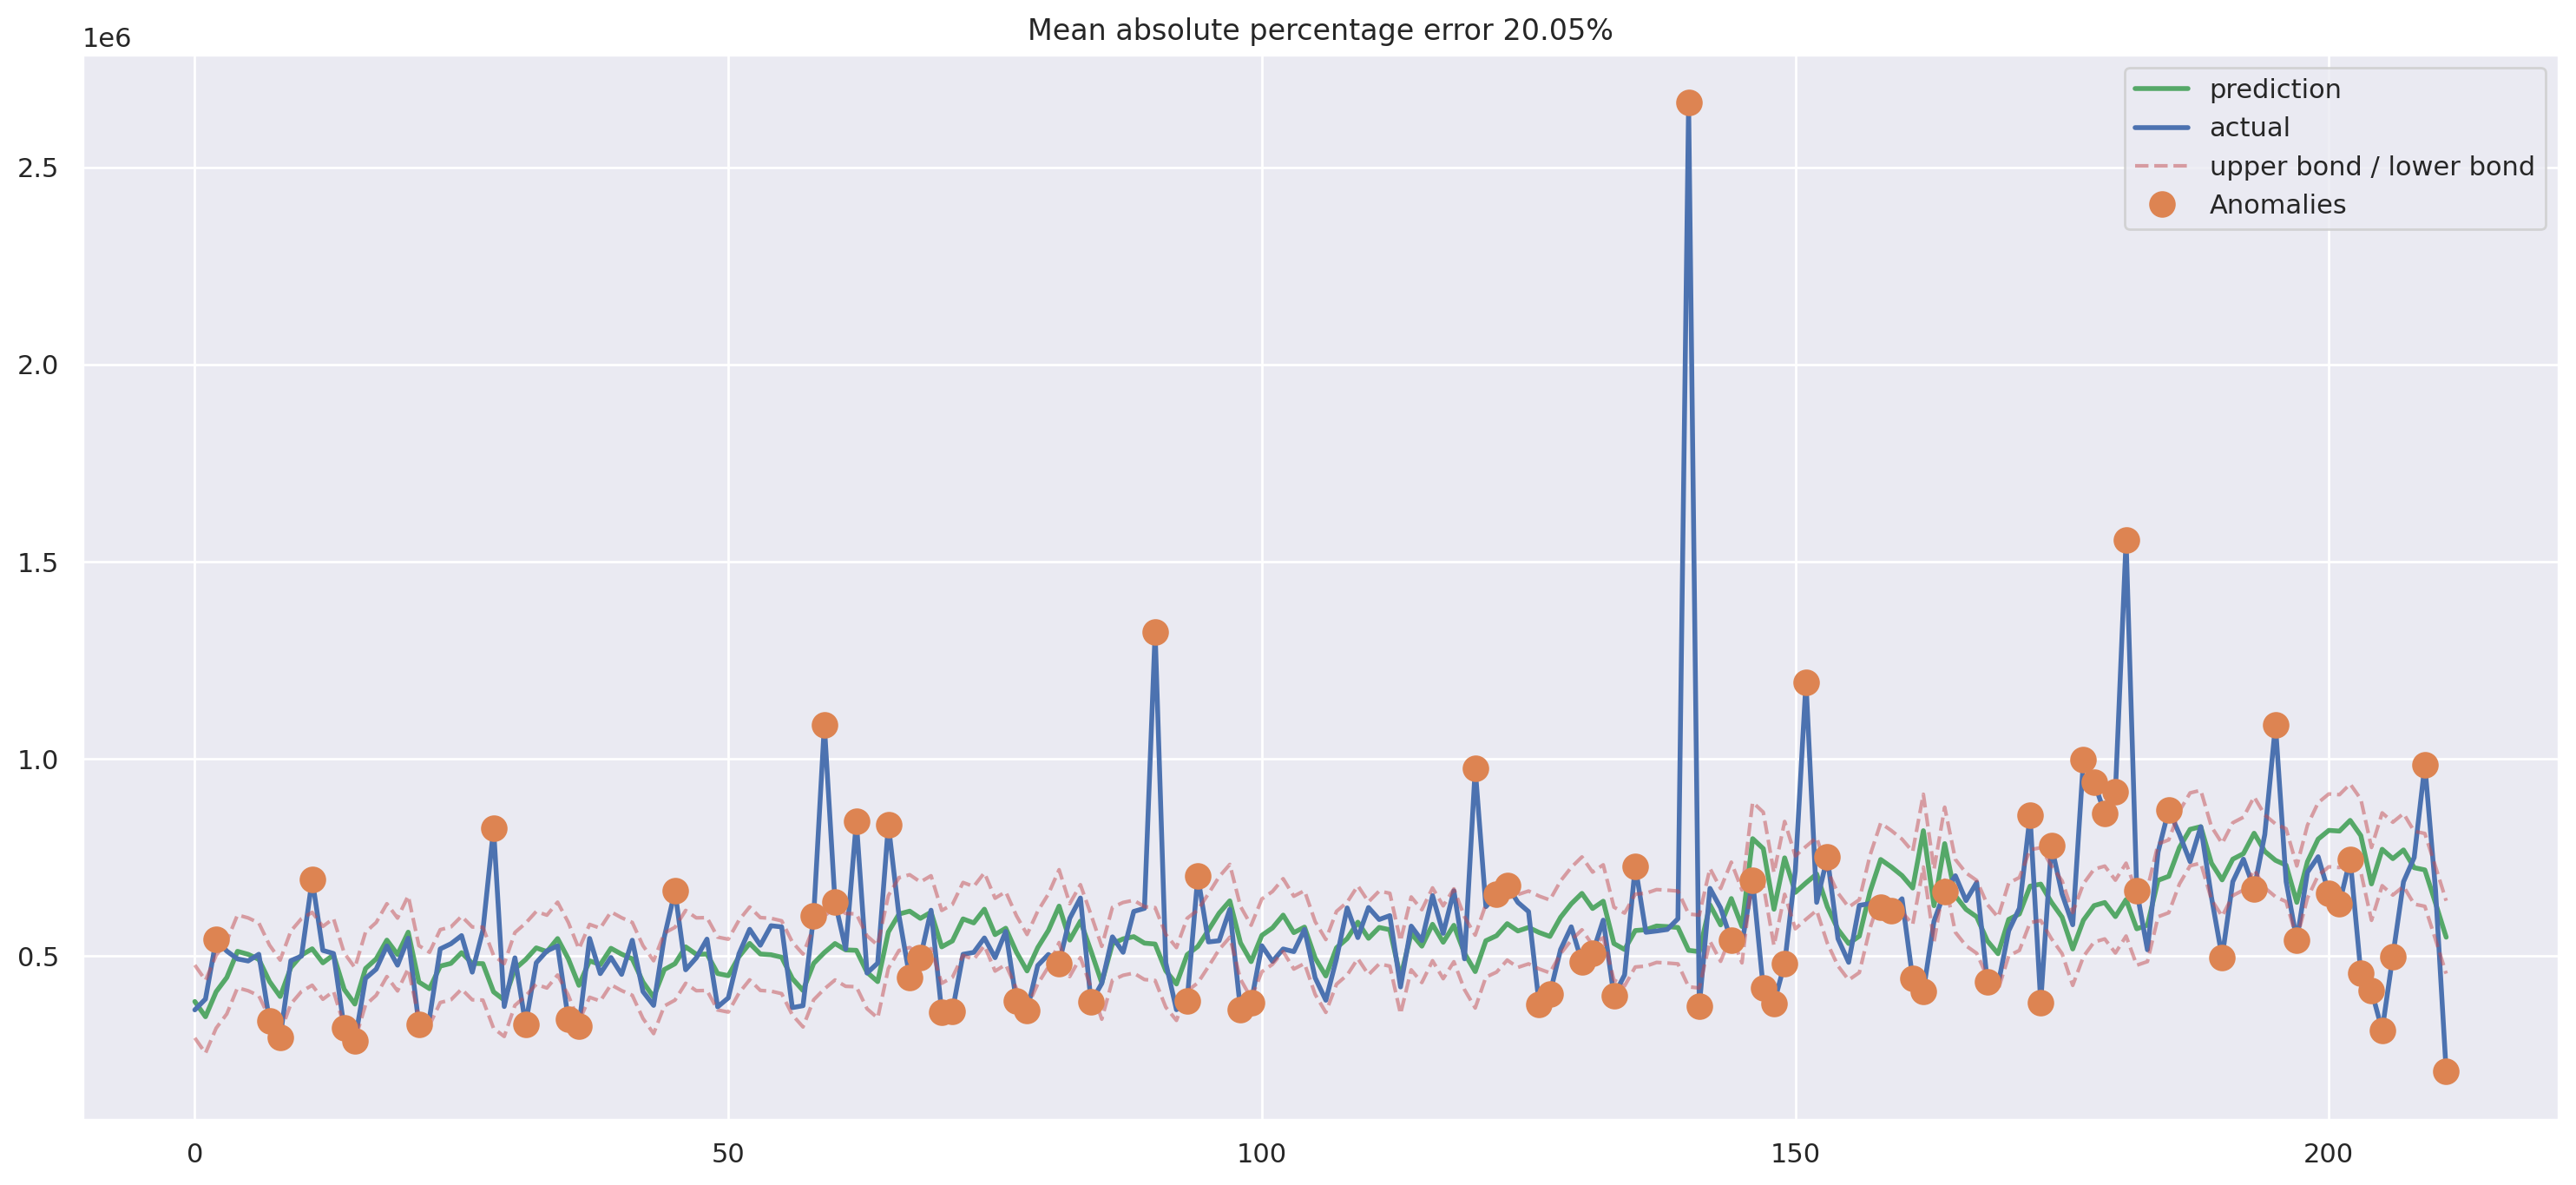

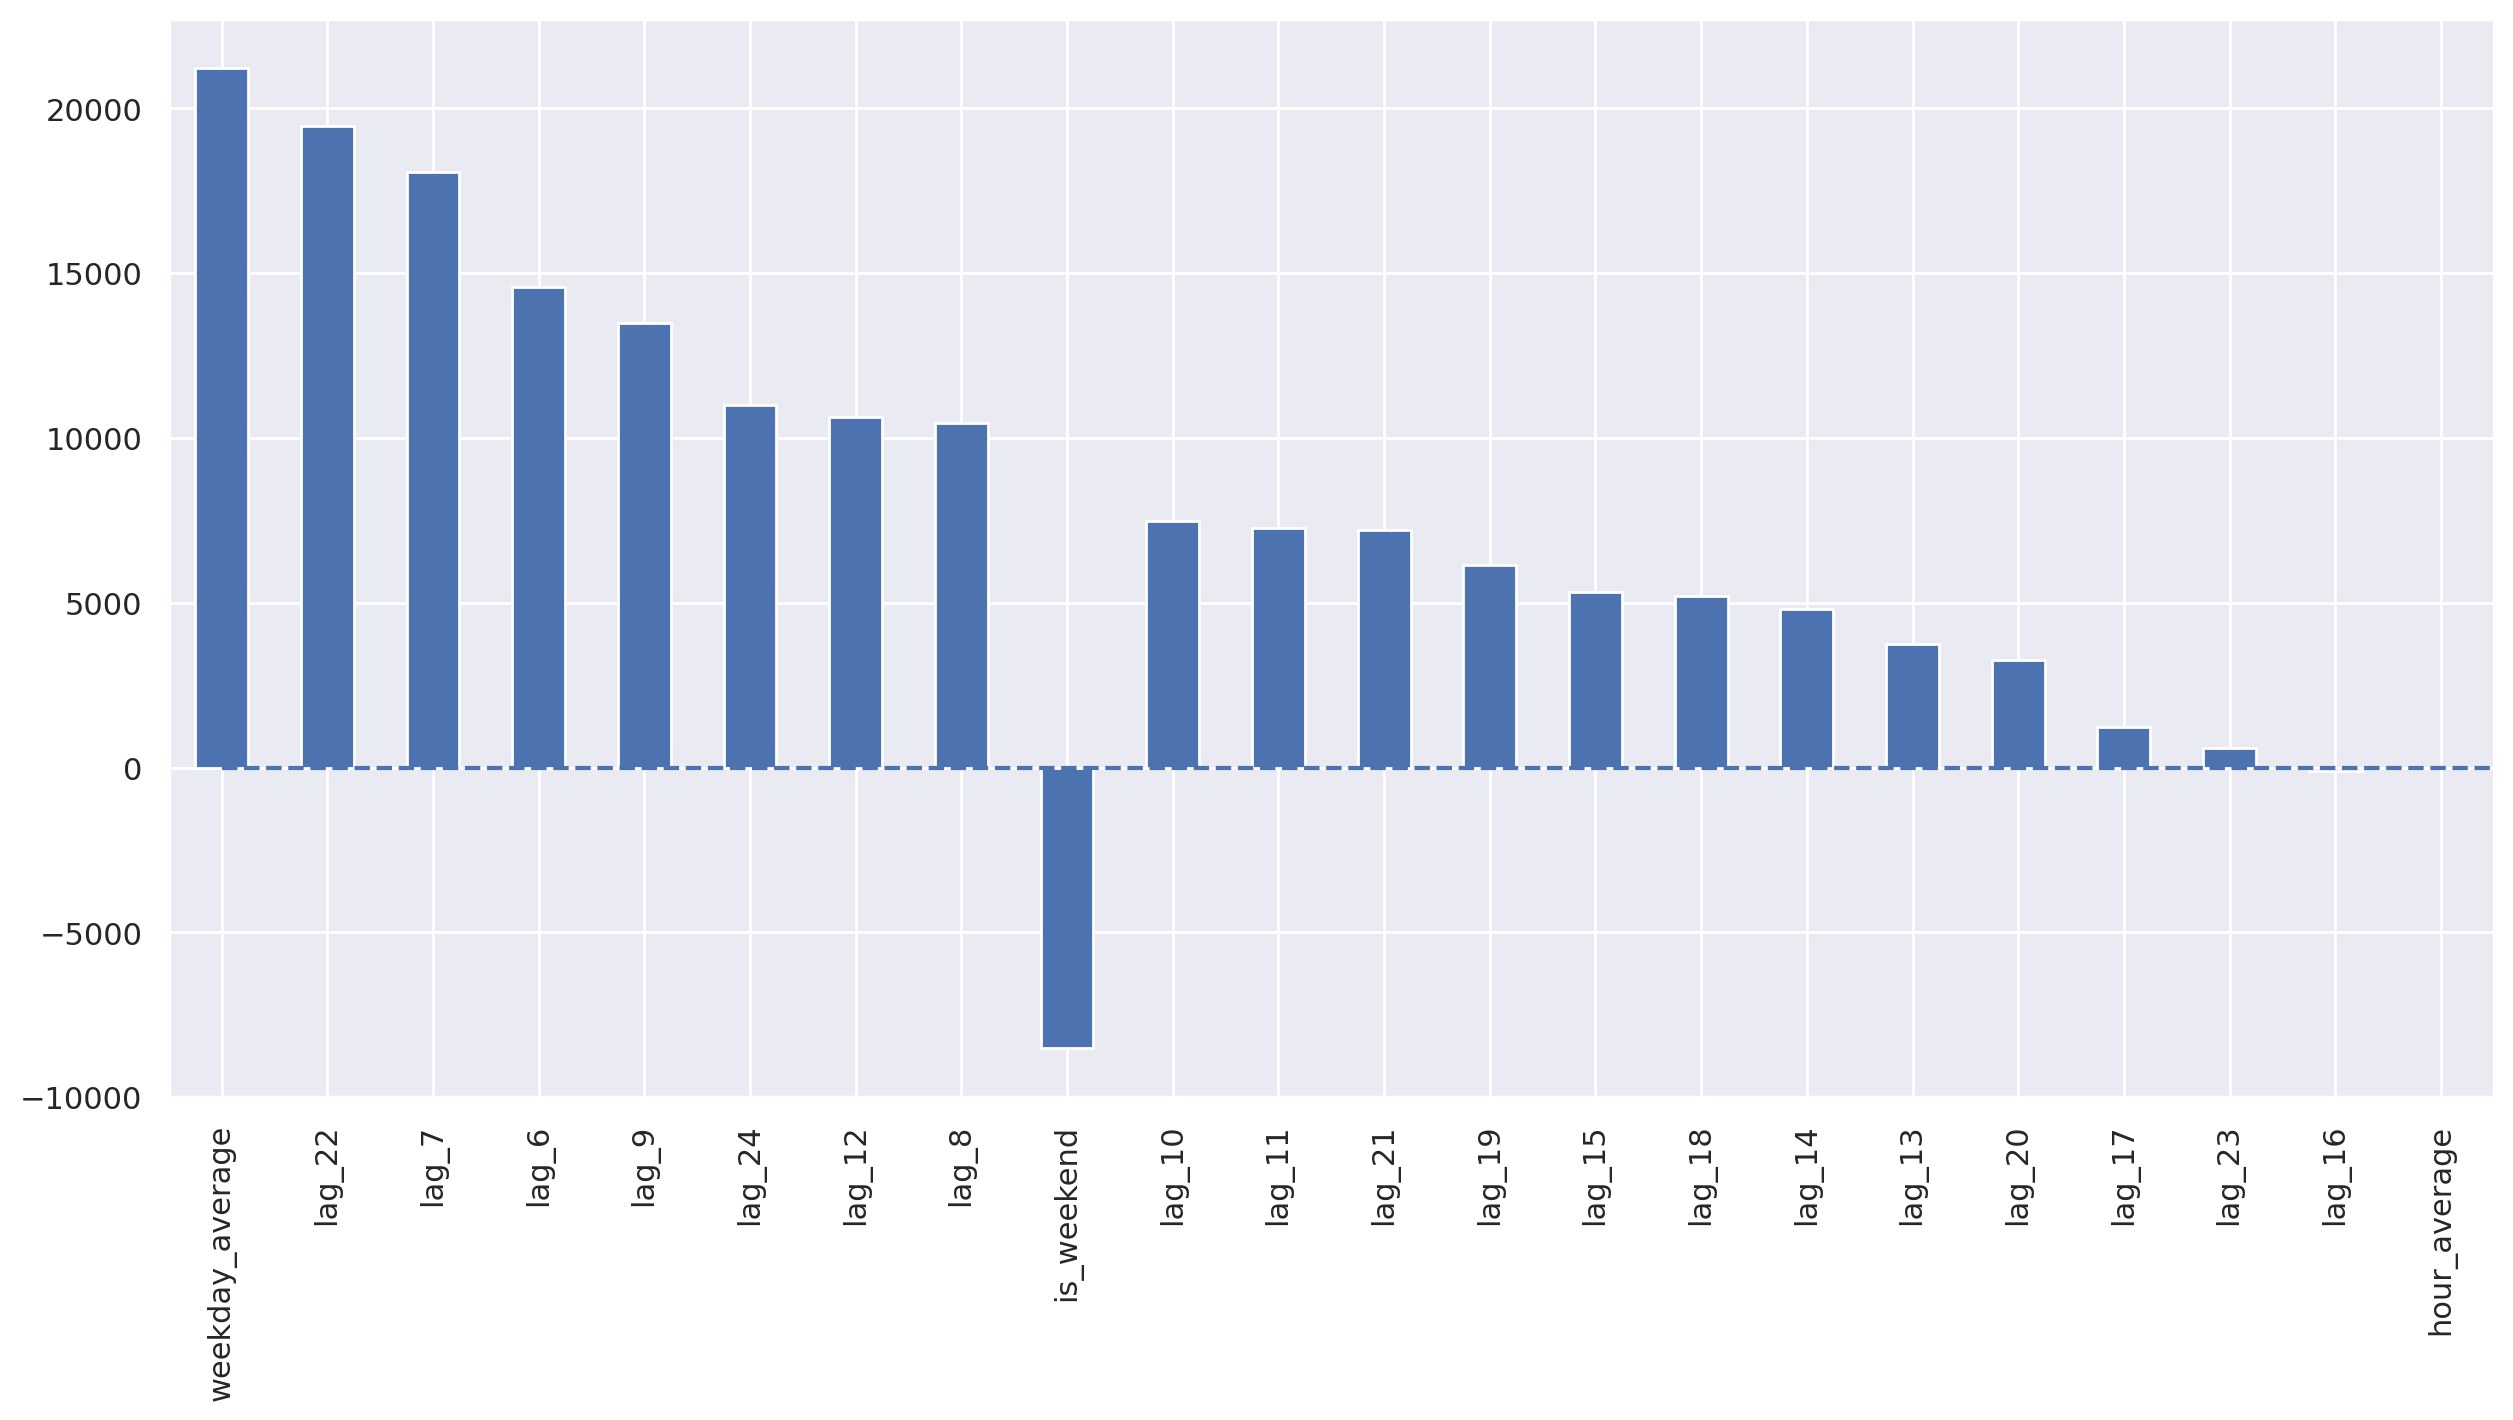

In [54]:
# Drop initial rows with missing values (NaN)
Data = Dollar_series.dropna()
# Split data into training and testing sets
X_train, X_test, y_train, y_test = prepareData(
    Data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

# Scale Data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


# Make prediction on the test set
y_pred = lr.predict(X_test)

plotModelResults(
    lr,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lr)

Mean Squared Error (MSE): 14496650425.709188
R-squared (R2): 0.7022691172229001


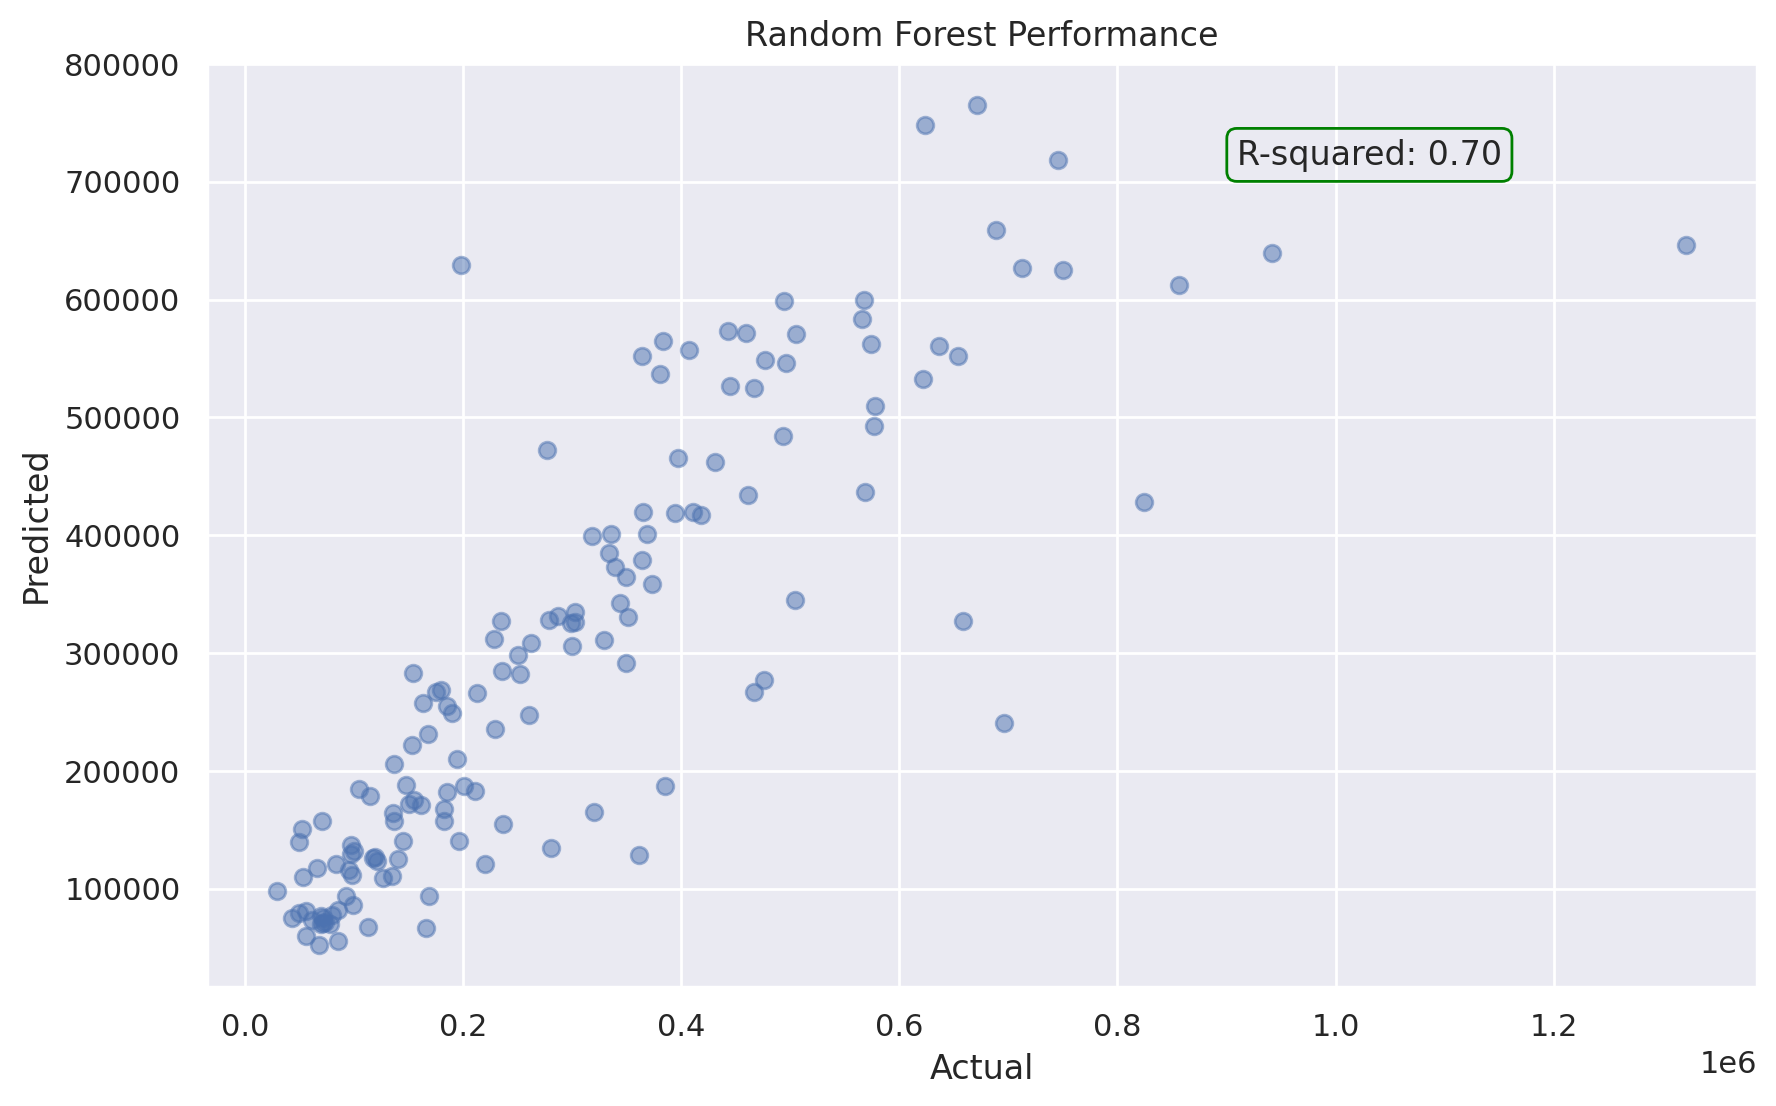

In [60]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Keeping the selected features as before
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# Create and fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

#Evaluate performance using nd appropriate metric
from sklearn.metrics import mean_squared_error,r2_score

mse_rf = mean_squared_error(y_test,y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5,label="Data")

# Add the R-squared value as text
r2_test = f"R-squared: {r2_rf:.2f}"
plt.text(0.75, 0.9, r2_test, ha="center",va="center", transform=plt.gca().transAxes, bbox=dict(boxstyle="round",facecolor='none', edgecolor='green'))

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Performance")
plt.show()

Mean Squared Error (MSE): 15425484567.289951
R-squared (R2): 0.6831928064334838


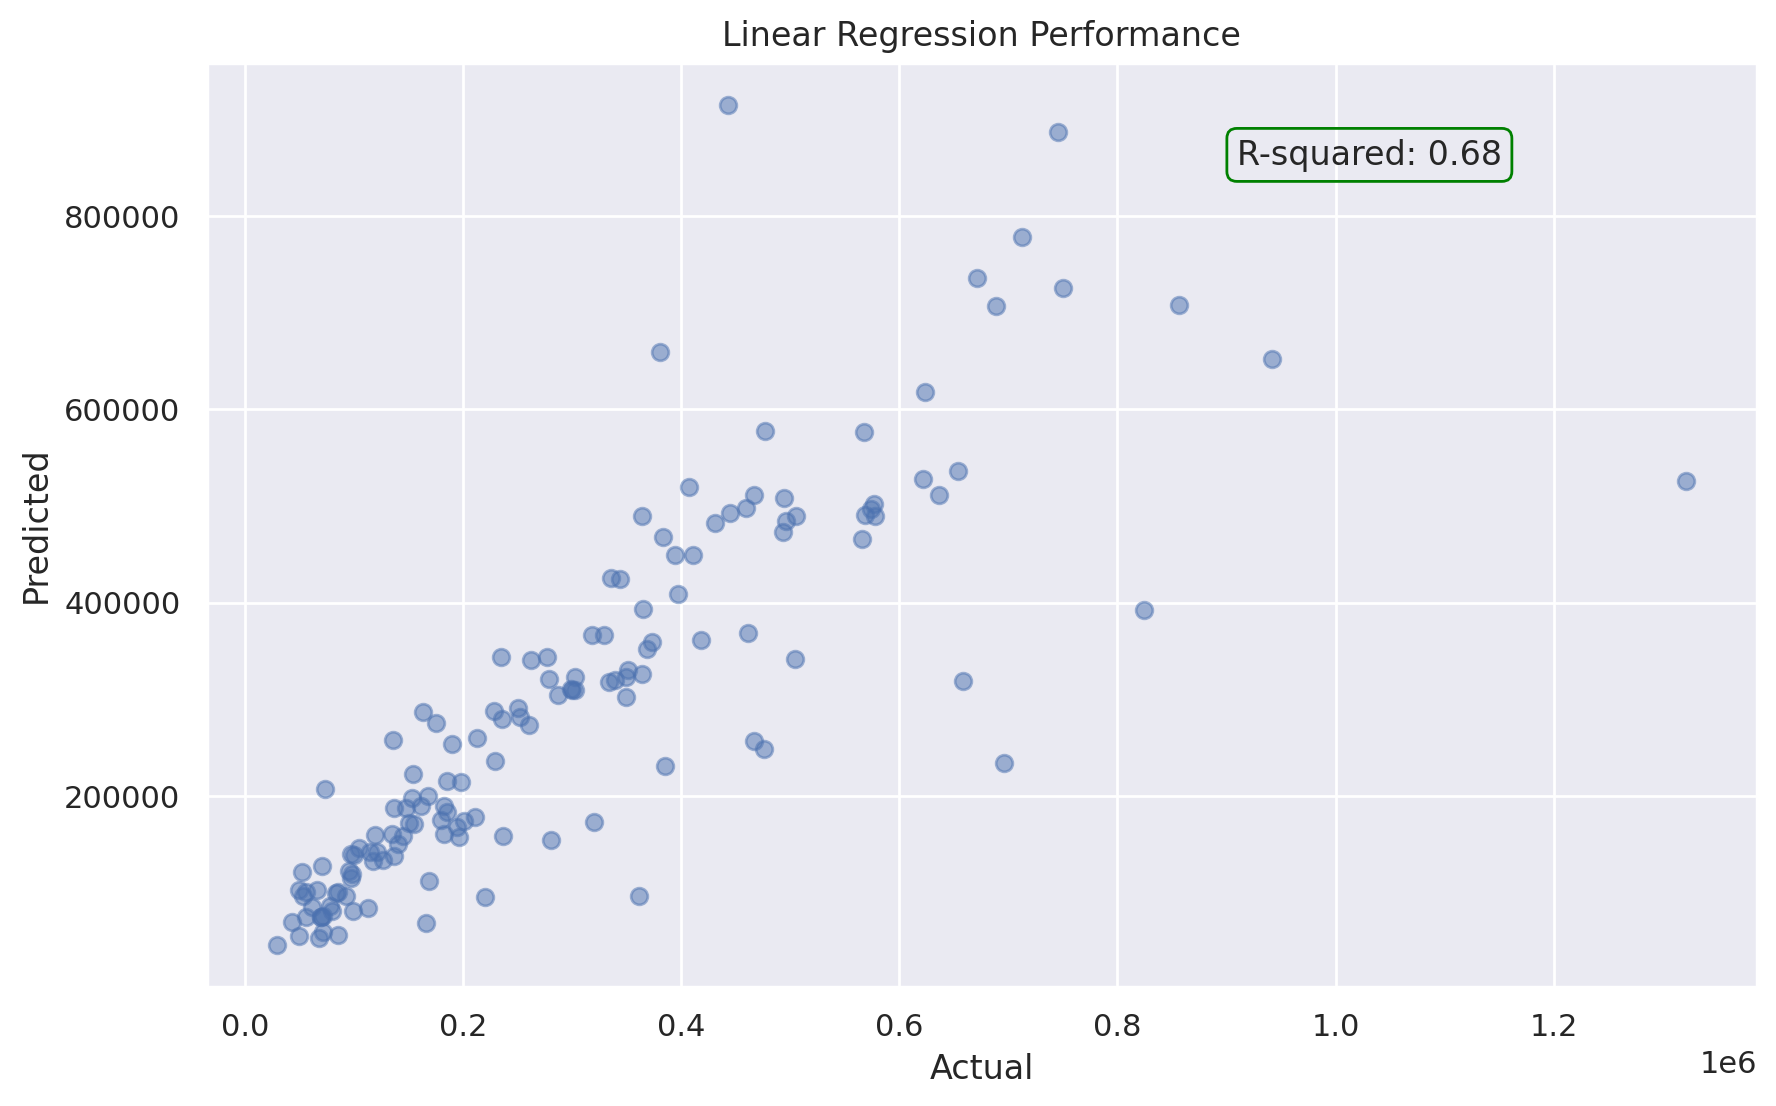

In [61]:
# Compare to Linear Regression Model
from sklearn.ensemble import RandomForestRegressor
# Keeping the selected features as before
# Spli data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# Create and fit the random forest model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

#Evaluate performance using nd appropriate metric
from sklearn.metrics import mean_squared_error,r2_score

mse_lr = mean_squared_error(y_test,y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"R-squared (R2): {r2_lr}")

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5,label="Data")

# Add the R-squared value as text
r2_test = f"R-squared: {r2_lr:.2f}"
plt.text(0.75, 0.9, r2_test, ha="center",va="center", transform=plt.gca().transAxes, bbox=dict(boxstyle="round",facecolor='none', edgecolor='green'))

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Performance")
plt.show()

In [57]:
# Conclusion: Linear Regression Model performs better than Random Forest Model

In [58]:
# Installing Prophet
#!pip install fbprophet
!pip install Prophet
import warnings
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

In [11]:
# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")].sort_values(by=['time'])

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 707 entries, 2033-01-24 to 2034-12-31
Freq: D
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lag_6   707 non-null    float64
 1   lag_7   707 non-null    float64
 2   lag_8   707 non-null    float64
 3   lag_9   707 non-null    float64
 4   lag_10  707 non-null    float64
 5   lag_11  707 non-null    float64
 6   lag_12  707 non-null    float64
 7   lag_13  707 non-null    float64
 8   lag_14  707 non-null    float64
 9   lag_15  707 non-null    float64
 10  lag_16  707 non-null    float64
 11  lag_17  707 non-null    float64
 12  lag_18  707 non-null    float64
 13  lag_19  707 non-null    float64
 14  lag_20  707 non-null    float64
 15  lag_21  707 non-null    float64
 16  lag_22  707 non-null    float64
 17  lag_23  707 non-null    float64
dtypes: float64(18)
memory usage: 104.9 KB


In [65]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2034-05-18 to 2033-02-17
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lag_6   142 non-null    float64
 1   lag_7   142 non-null    float64
 2   lag_8   142 non-null    float64
 3   lag_9   142 non-null    float64
 4   lag_10  142 non-null    float64
 5   lag_11  142 non-null    float64
 6   lag_12  142 non-null    float64
 7   lag_13  142 non-null    float64
 8   lag_14  142 non-null    float64
 9   lag_15  142 non-null    float64
 10  lag_16  142 non-null    float64
 11  lag_17  142 non-null    float64
 12  lag_18  142 non-null    float64
 13  lag_19  142 non-null    float64
 14  lag_20  142 non-null    float64
 15  lag_21  142 non-null    float64
 16  lag_22  142 non-null    float64
 17  lag_23  142 non-null    float64
dtypes: float64(18)
memory usage: 21.1 KB


In [66]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly
init_notebook_mode(connected=True)

In [ ]:
X.head()

lag_6     lag_7     lag_8     lag_9    lag_10    lag_11  \
time                                                                     
2033-01-24  19194.69  18953.62  11087.61  15817.95  41119.03  34005.18   
2033-01-25  32943.04  19194.69  18953.62  11087.61  15817.95  41119.03   
2033-01-26  18733.76  32943.04  19194.69  18953.62  11087.61  15817.95   
2033-01-27  18221.52  18733.76  32943.04  19194.69  18953.62  11087.61   
2033-01-28  27234.13  18221.52  18733.76  32943.04  19194.69  18953.62   

                lag_12      lag_13      lag_14      lag_15      lag_16  \
time                                                                     
2033-01-24  1210293.14   241898.77    20481.44     9100.92    10977.77   
2033-01-25    34005.18  1210293.14   241898.77    20481.44     9100.92   
2033-01-26    41119.03    34005.18  1210293.14   241898.77    20481.44   
2033-01-27    15817.95    41119.03    34005.18  1210293.14   241898.77   
2033-01-28    11087.61    15817.95    41119.03    34005.18  1210293.14   

               lag_17    lag_18    lag_19    lag_20    lag_21    lag_22  \
time                                                                      
2033-01-24   92925.77  11055.98  10016.21   4851.11   6283.53   4758.62   
2033-01-25   10977.77  92925.77  11055.98  10016.21   4851.11   6283.53   
2033-01-26    9100.92  10977.77  92925.77  11055.98  10016.21   4851.11   
2033-01-27   20481.44   9100.92  10977.77  92925.77  11055.98  10016.21   
2033-01-28  241898.77  20481.44   9100.92  10977.77  92925.77  11055.98   

              lag_23  
time                  
2033-01-24   4415.40  
2033-01-25   4758.62  
2033-01-26   6283.53  
2033-01-27   4851.11  
2033-01-28  10016.21

In [75]:
y.head()

time
2033-01-24    30777.09
2033-01-25    21963.14
2033-01-26    72914.78
2033-01-27    20217.99
2033-01-28    36659.05
Freq: D, Name: y, dtype: float64

In [73]:
#df = X.reset_index()
df = y.reset_index()
df.head()

time         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [74]:
df.head()

time         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [77]:
# Conver datafreame to the format requred by Prophet
#df.columns = ['ds','lag_6','lag_7','lag_8','lag_9','lag_10','lag_11','lag_12','lag_13','lag_14','lag_15','lag_16','lag_17','lag_18','lag_19','lag_20','lag_21','lag_22','lag_23']
df.columns = ["ds",'y']
df.head(n=3)

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78

In [78]:
y

time
2033-01-24     30777.09
2033-01-25     21963.14
2033-01-26     72914.78
2033-01-27     20217.99
2033-01-28     36659.05
                ...    
2034-12-27    688573.47
2034-12-28    750020.80
2034-12-29    984672.08
2034-12-30    668559.95
2034-12-31    208533.08
Freq: D, Name: y, Length: 707, dtype: float64

In [80]:
# Split dataset into historical part and prediction part.  Remove the last month from the dataset in order to use it later as prediction target
prediction_size = 30
train_df = df[:-prediction_size]
train_df.head(n=3)

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78

In [81]:
# Create a new Prophet Object.
m=Prophet()
m.fit(train_df);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqbe7mu7/ltd6pt60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqbe7mu7/ko7ugawh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88978', 'data', 'file=/tmp/tmpuqbe7mu7/ltd6pt60.json', 'init=/tmp/tmpuqbe7mu7/ko7ugawh.json', 'output', 'file=/tmp/tmpuqbe7mu7/prophet_modellusrw57p/prophet_model-20240309022759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:27:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:28:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [83]:
train_df.head()

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [86]:
# Crate dataframe which will contain all dates from the history and also extend into the future for those 30 days that we left out before
future = m.make_future_dataframe(periods=prediction_size)
future.head(n=3)

ds
0 2033-01-24
1 2033-01-25
2 2033-01-26

In [87]:
forecast=m.predict(future)
forecast.tail(n=3)

ds          trend     yhat_lower     yhat_upper    trend_lower  \
704 2034-12-29  709679.152925  587477.663571  930875.464477  709255.412668   
705 2034-12-30  710892.281813  504157.709364  852382.566177  710448.116644   
706 2034-12-31  712105.410701  452234.663790  799794.764414  711632.883661   

       trend_upper  additive_terms  additive_terms_lower  \
704  710147.820423    53533.771706          53533.771706   
705  711384.896184   -35849.787220         -35849.787220   
706  712623.265427   -84002.785243         -84002.785243   

     additive_terms_upper        weekly  weekly_lower  weekly_upper  \
704          53533.771706  53533.771706  53533.771706  53533.771706   
705         -35849.787220 -35849.787220 -35849.787220 -35849.787220   
706         -84002.785243 -84002.785243 -84002.785243 -84002.785243   

     multiplicative_terms  multiplicative_terms_lower  \
704                   0.0                         0.0   
705                   0.0                         0.0   
706                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
704                         0.0  763212.924631  
705                         0.0  675042.494593  
706                         0.0  628102.625458

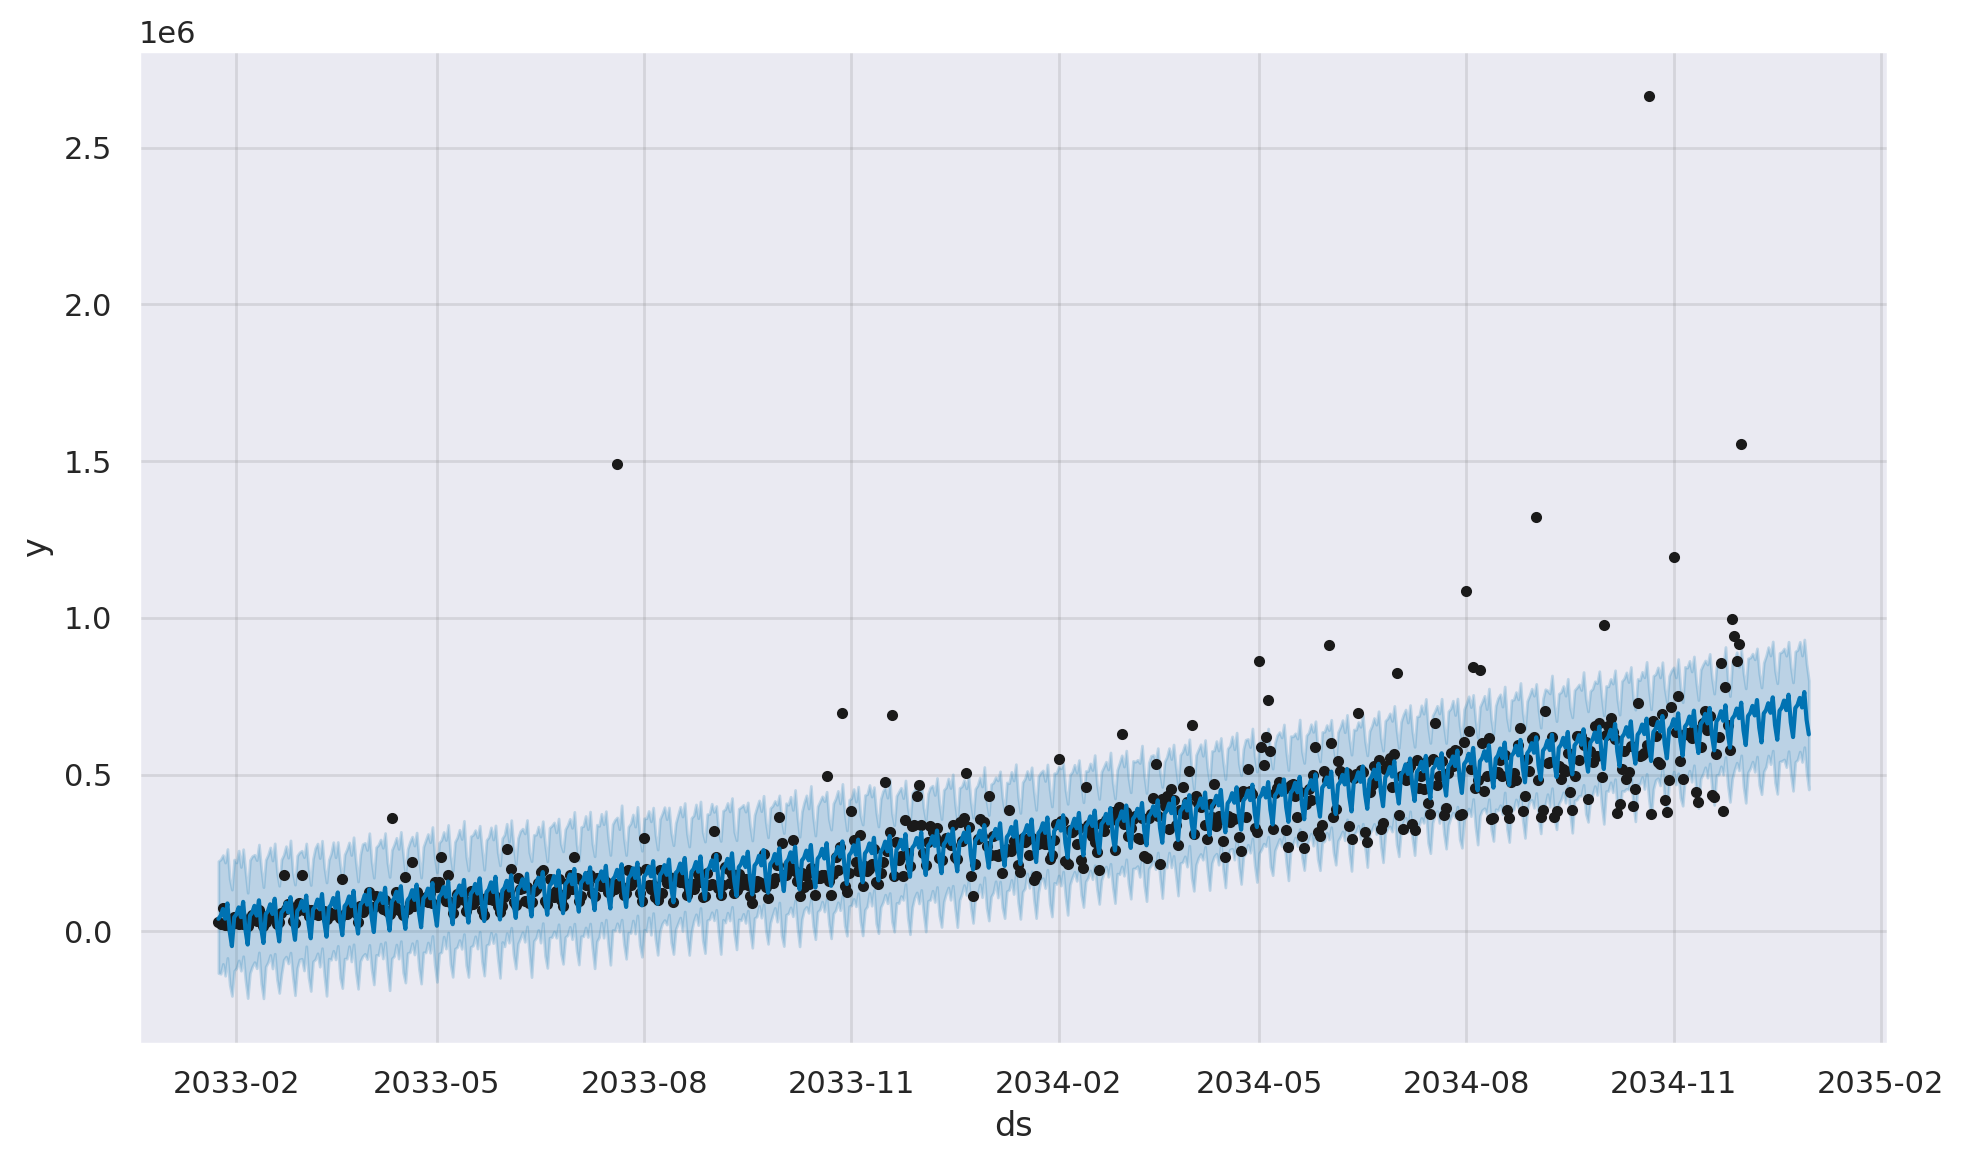

In [88]:
# Use Prophet Plot
m.plot(forecast);

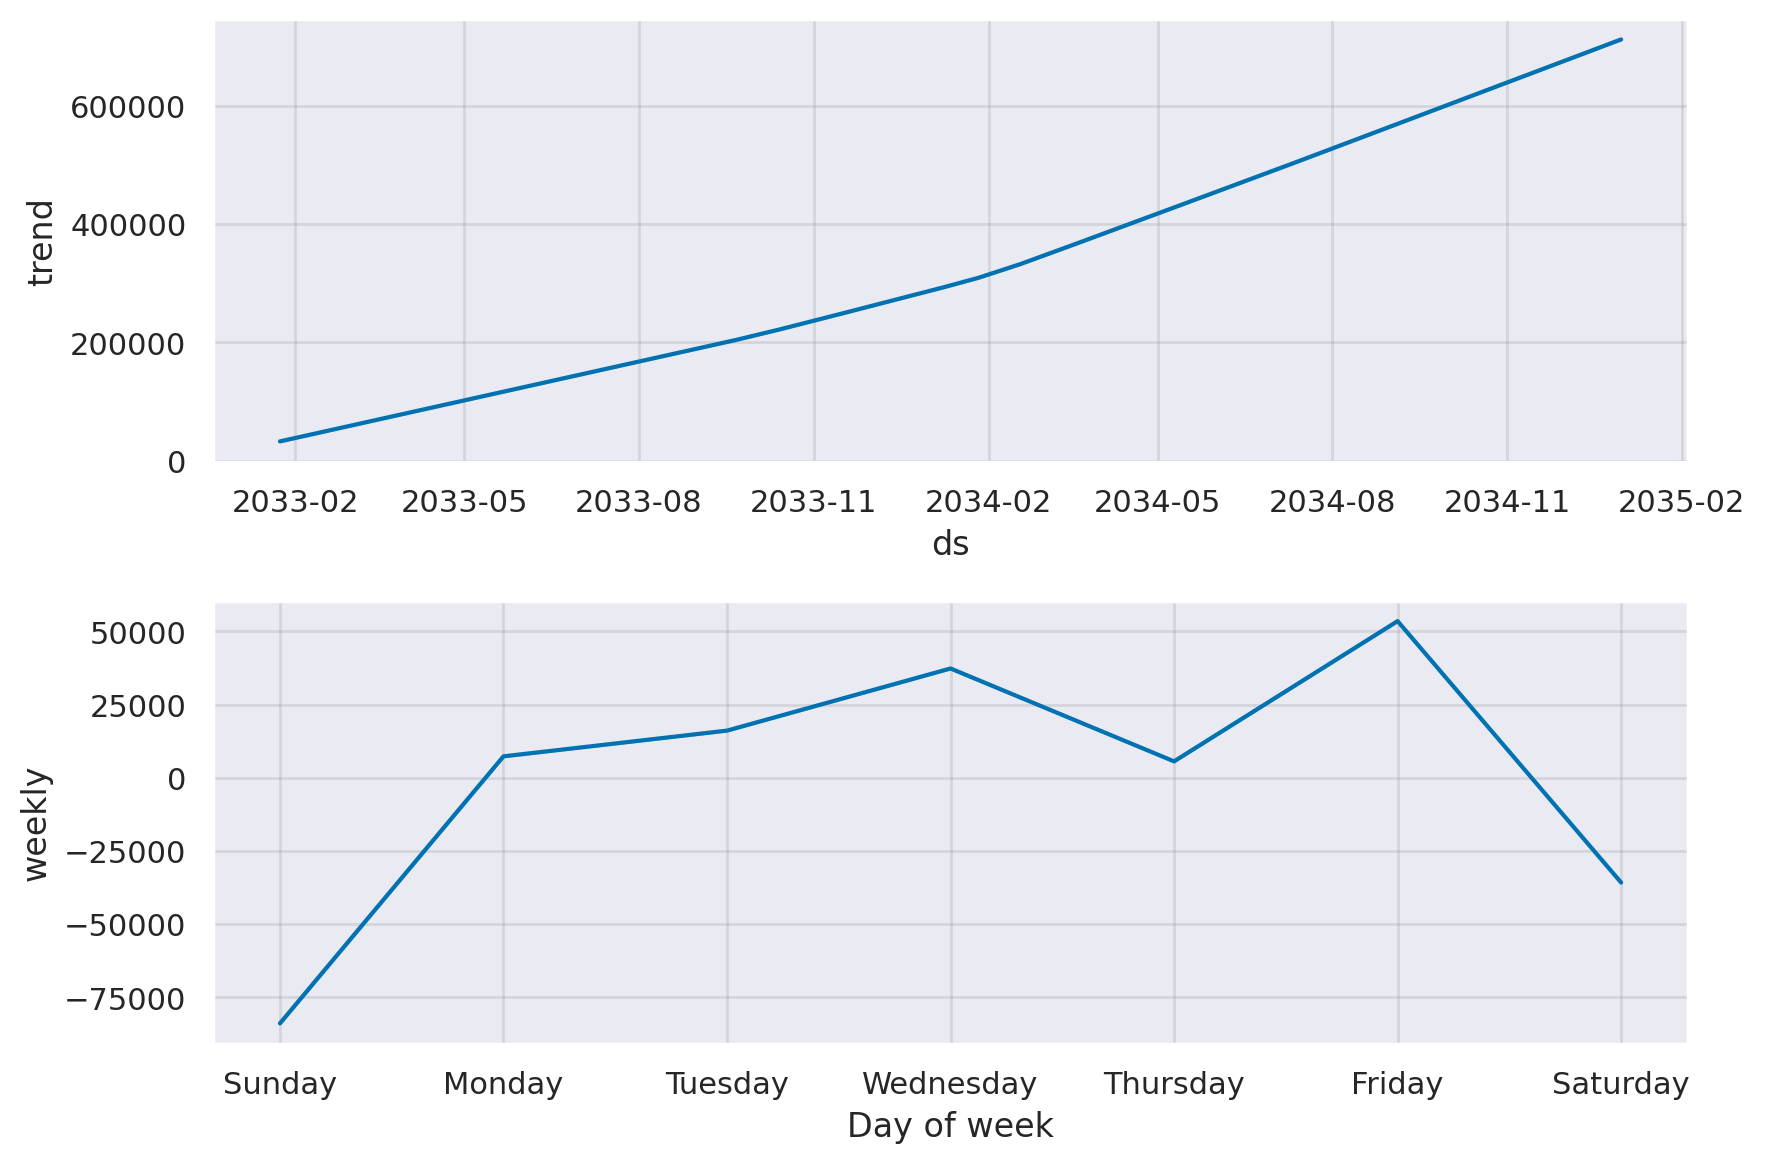

In [89]:
# Let's see different componentss of the model separetely
m.plot_components(forecast);

In [90]:
# From the trend graph, Prophet did a good job fitting the accelerated groth as well as the weekly seasonality as there are
# negative (or less than 0 ) activity on Saturday and Sunday

In [ ]:
print(",".join(forecast.columns))

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat


In [91]:
df.head()

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [92]:
def make_comparison_dataframe(historical, forecast):
  """Join the history with the forecast.forecast
    The resulting dataset will contain columns 'yhat', 'yaht_lowr', 'yhat_upper' and 'y'.
  """
  return forecast.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].join(historical.set_index("ds"))

In [94]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head(n=3)

yhat     yhat_lower     yhat_upper         y
ds                                                              
2033-01-24  39669.398383 -133383.442706  223557.373215  30777.09
2033-01-25  49177.372802 -135620.193773  229184.131317  21963.14
2033-01-26  71134.099313 -103952.709821  243107.928127  72914.78

In [104]:
df.head()

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [105]:
data = pd.read_csv('daily_transactions.csv', index_col = 'time', parse_dates=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqbe7mu7/l70nn0rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqbe7mu7/jb_76hak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92937', 'data', 'file=/tmp/tmpuqbe7mu7/l70nn0rv.json', 'init=/tmp/tmpuqbe7mu7/jb_76hak.json', 'output', 'file=/tmp/tmpuqbe7mu7/prophet_modelmlvicm_n/prophet_model-20240309023258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


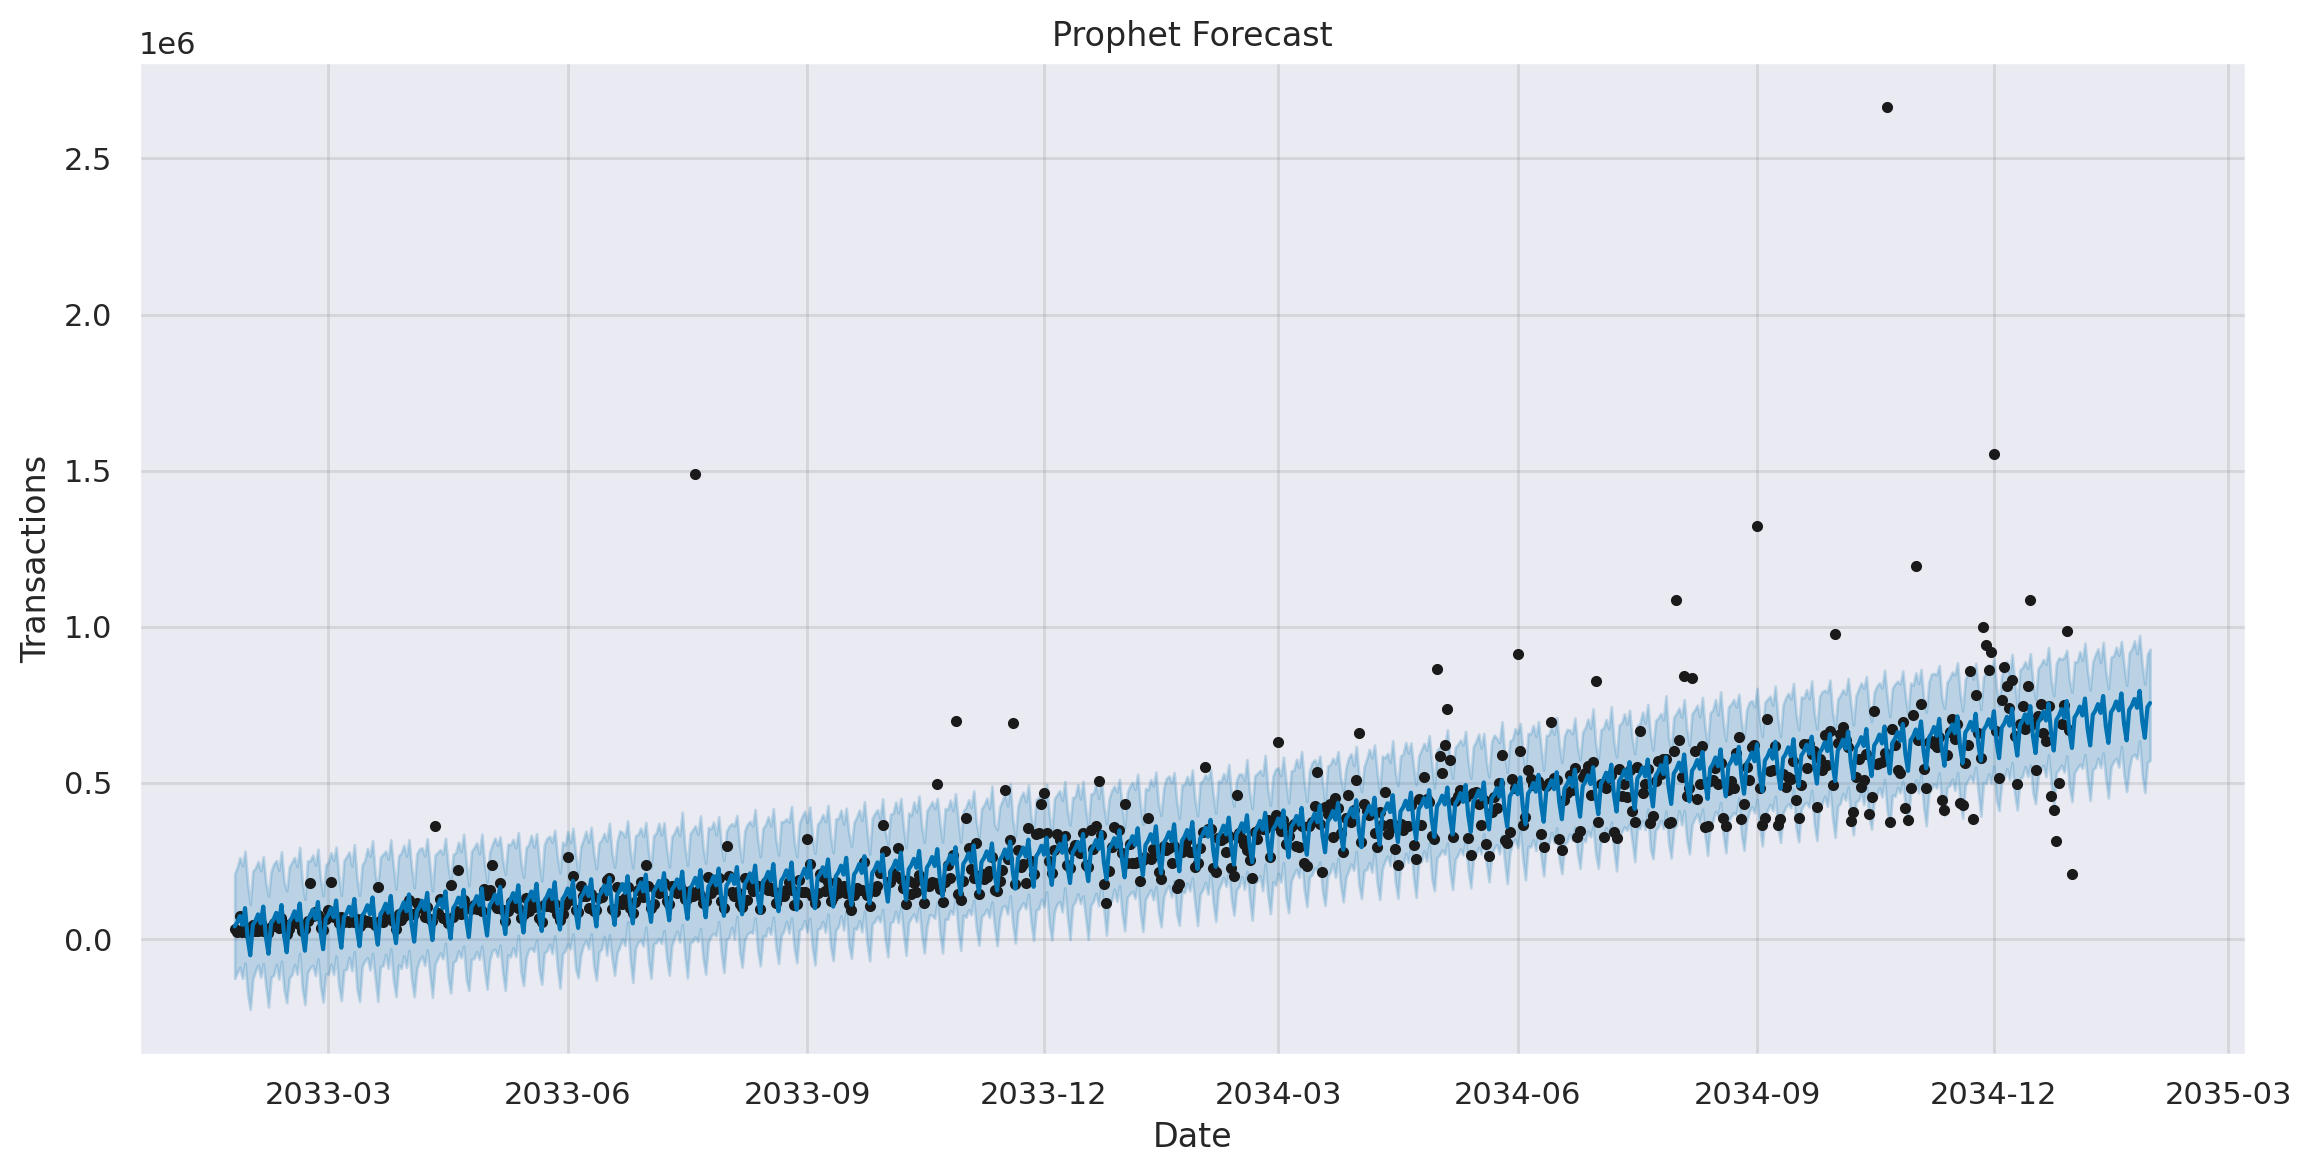

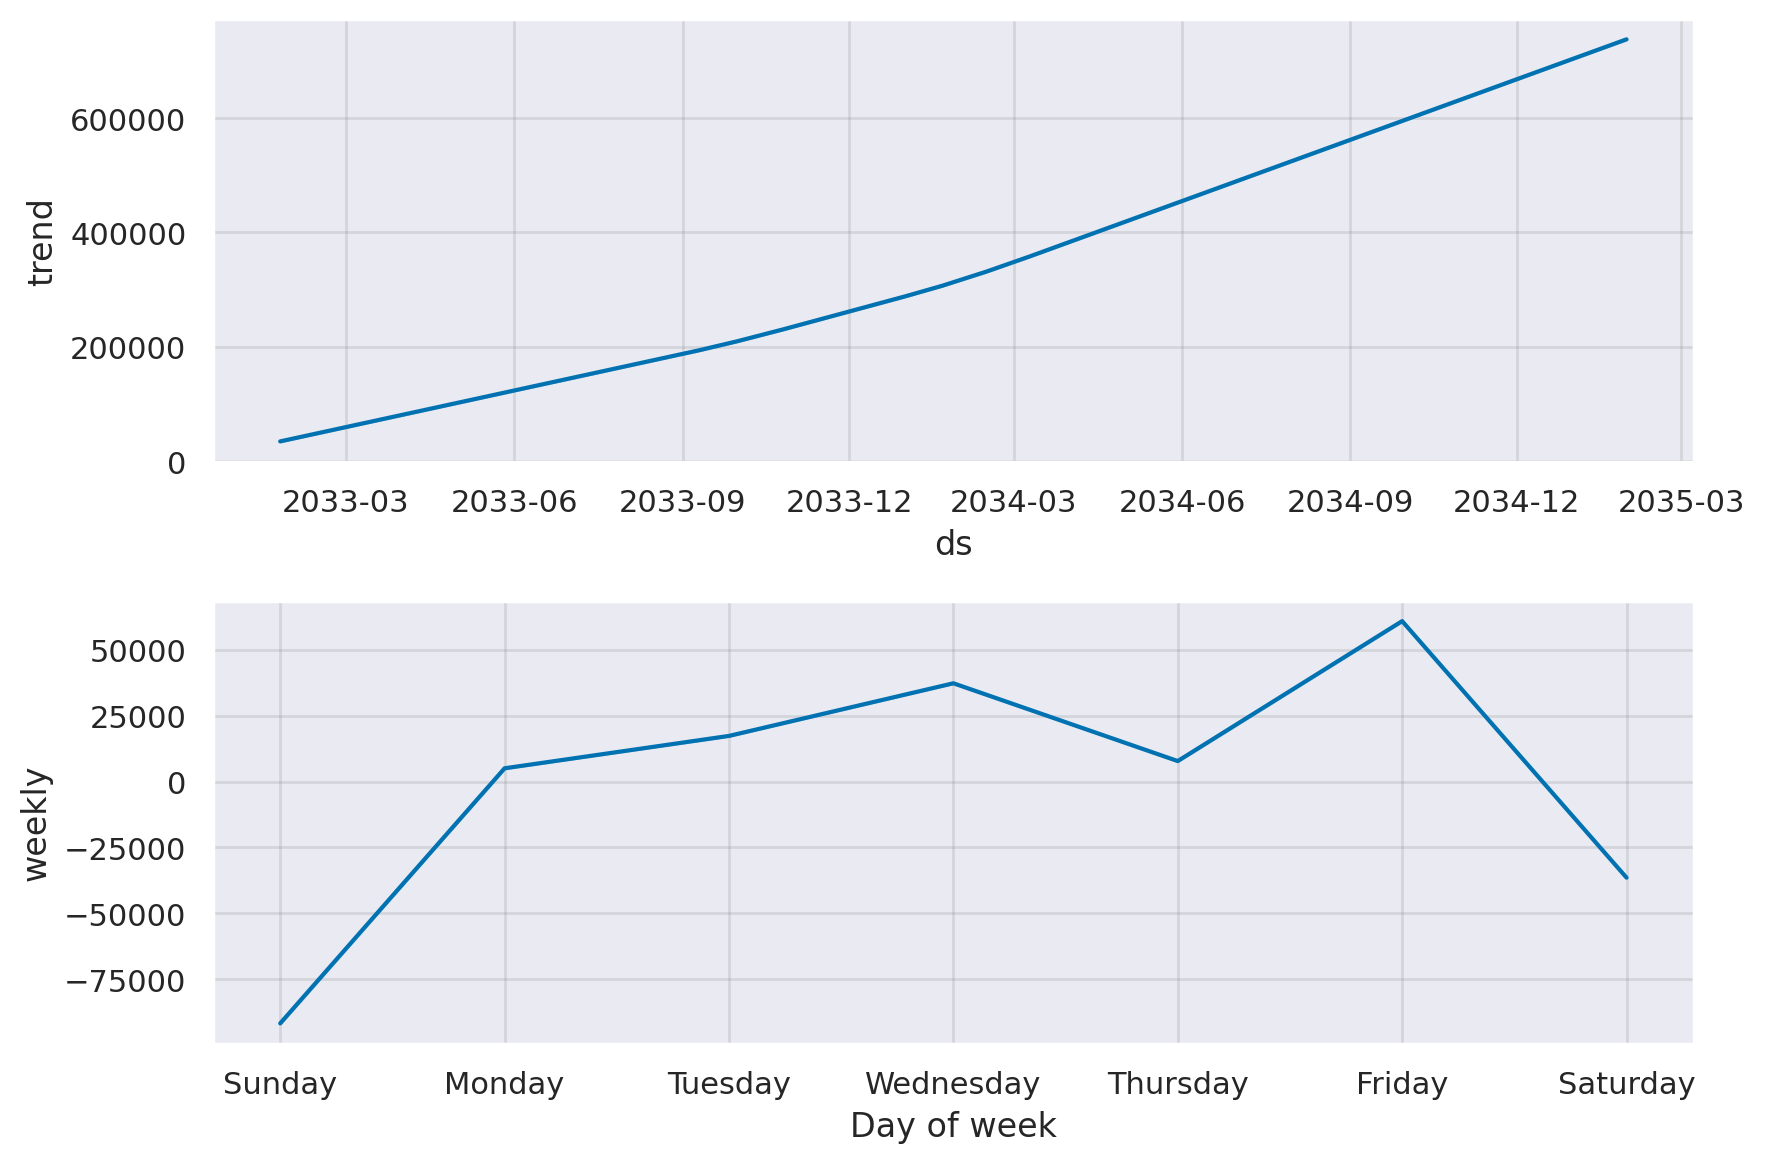

In [95]:
# Here is an alternative way of performing above steps
import pandas as pd
!pip install prophet
from prophet import Prophet

# Prepare data in the format required by Prophet
df.columns = ["ds","y"]
df_prophet = df

# Alternative way
#df_prophet = pd.DataFrame({"ds": data.index, "y": data["amount_usd_in_cents"]})  # Assume "amount" is your transaction column
#df_prophet = series.reset_index()

# Create and fit the Prophet model
model = Prophet()  # Optionally specify seasonalities or changepoints
model.fit(df_prophet)

# Define the period for which we want a forecast
future_dates = pd.date_range(start=df_prophet.ds.max(), periods=30, freq="D")
forecast_df = model.make_future_dataframe(periods=len(future_dates))

# Generate the forecast
forecast = model.predict(forecast_df)

# Plot the results
fig = model.plot(forecast)
fig.set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Prophet Forecast")
plt.show()

# (Optional) Plot components of the forecast
fig2 = model.plot_components(forecast)

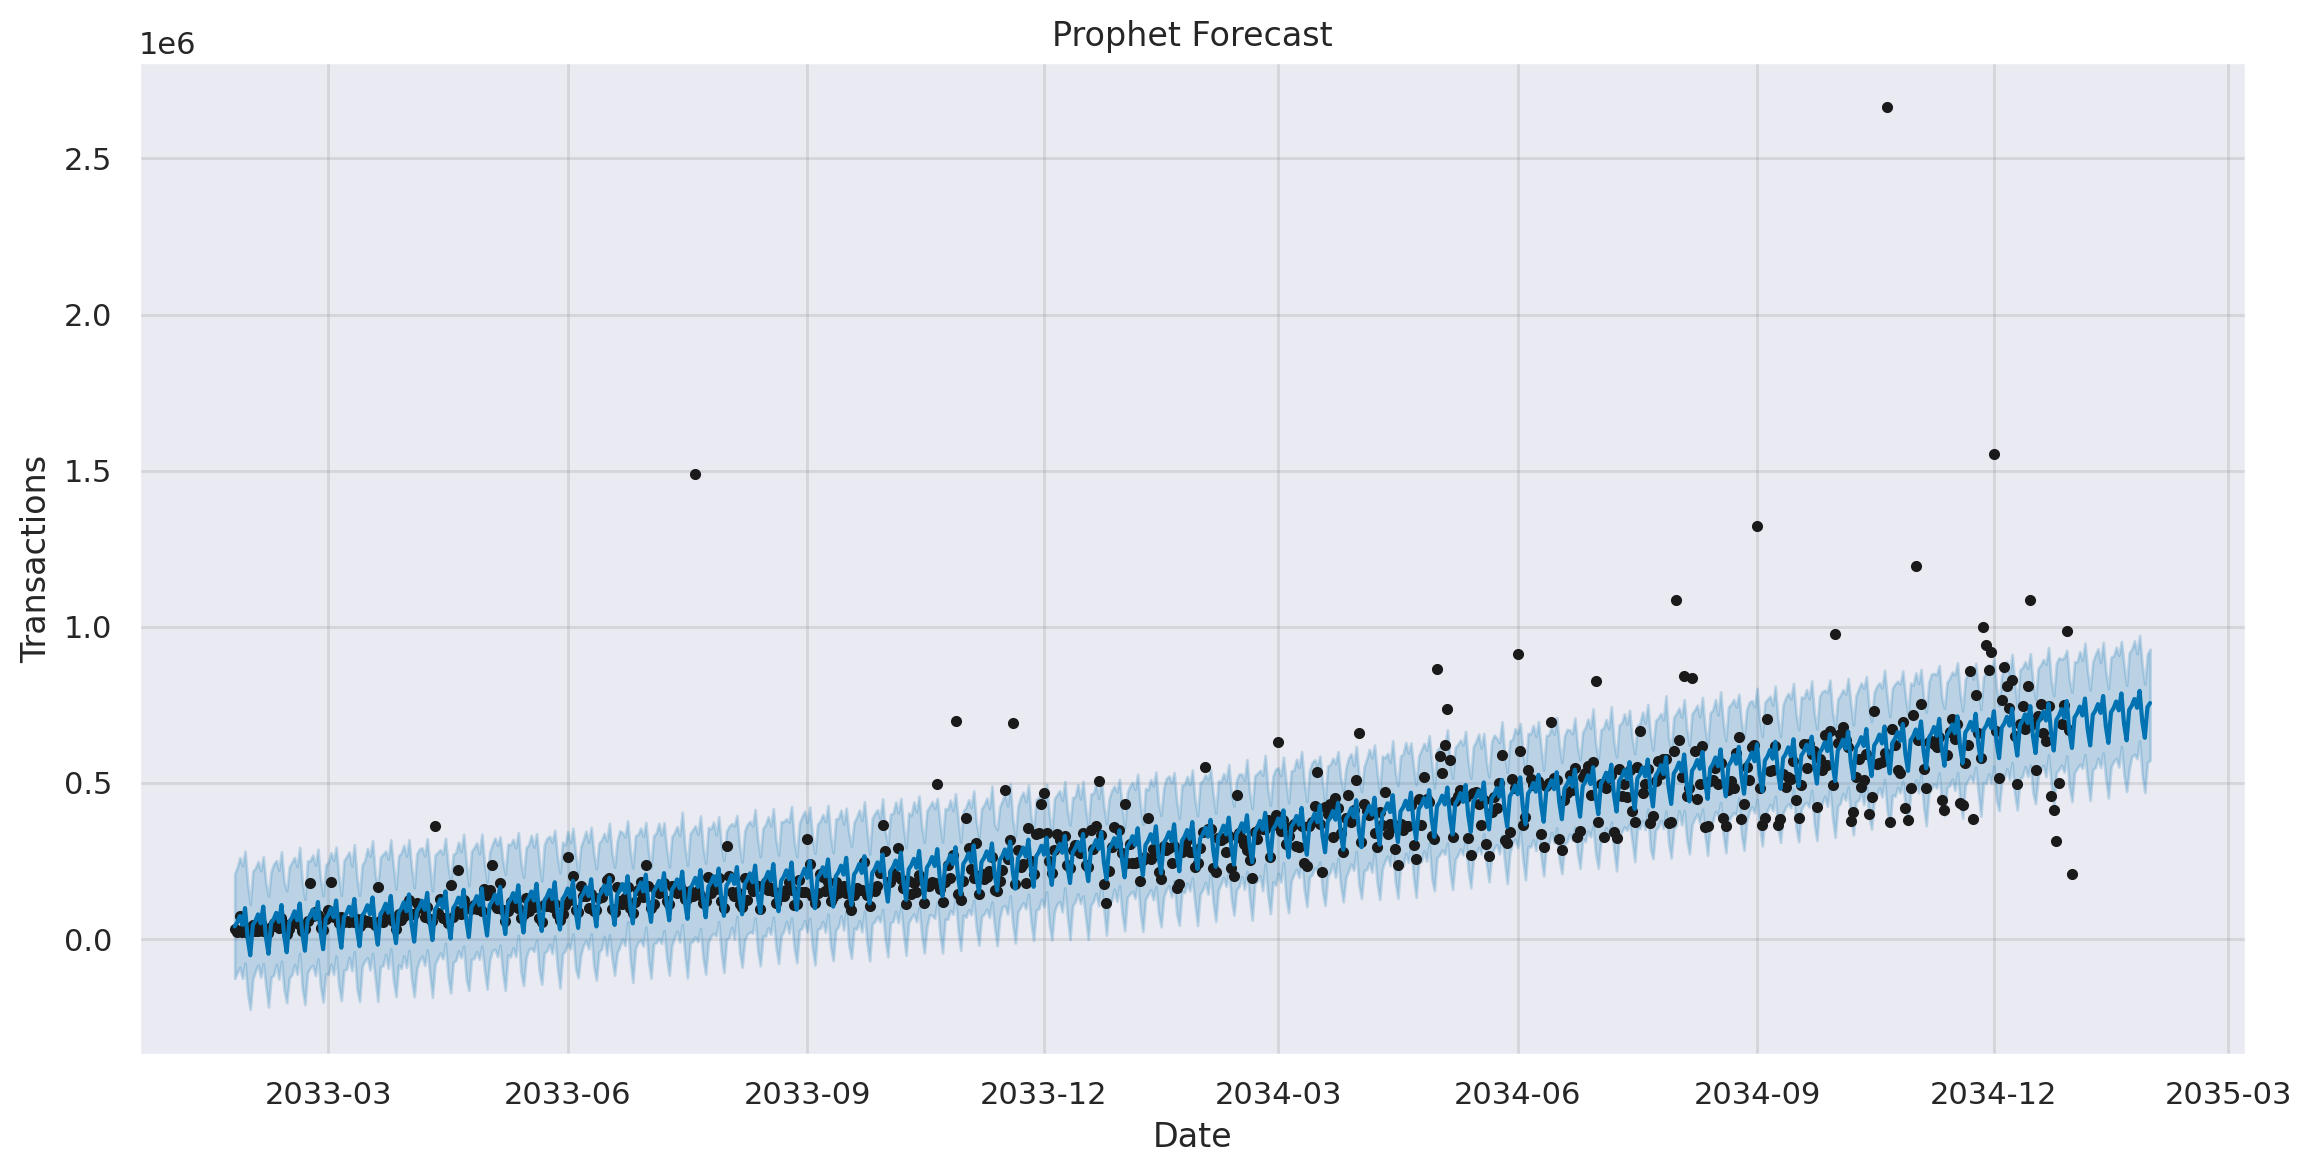

In [96]:
fig = model.plot(forecast)
fig.set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Prophet Forecast")
plt.show()

In [ ]:
# Forcast Metrics Computations

In [97]:
forecast.head()

ds         trend     yhat_lower     yhat_upper   trend_lower  \
0 2033-01-24  34377.730317 -127434.248227  207402.131950  34377.730317   
1 2033-01-25  35072.988745 -108945.416302  228747.172938  35072.988745   
2 2033-01-26  35768.247174  -91812.175197  259785.980588  35768.247174   
3 2033-01-27  36463.505603 -127349.226806  233358.452145  36463.505603   
4 2033-01-28  37158.764031  -77813.229763  280668.110564  37158.764031   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  34377.730317     5019.457375           5019.457375           5019.457375   
1  35072.988745    17306.440216          17306.440216          17306.440216   
2  35768.247174    37272.984723          37272.984723          37272.984723   
3  36463.505603     7765.300364           7765.300364           7765.300364   
4  37158.764031    60853.651874          60853.651874          60853.651874   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0   5019.457375   5019.457375   5019.457375                   0.0   
1  17306.440216  17306.440216  17306.440216                   0.0   
2  37272.984723  37272.984723  37272.984723                   0.0   
3   7765.300364   7765.300364   7765.300364                   0.0   
4  60853.651874  60853.651874  60853.651874                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  39397.187692  
1                         0.0                         0.0  52379.428961  
2                         0.0                         0.0  73041.231897  
3                         0.0                         0.0  44228.805967  
4                         0.0                         0.0  98012.415905

In [100]:
df.head()


ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [98]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [99]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head(n=5)

yhat     yhat_lower     yhat_upper         y
ds                                                              
2033-01-24  39397.187692 -127434.248227  207402.131950  30777.09
2033-01-25  52379.428961 -108945.416302  228747.172938  21963.14
2033-01-26  73041.231897  -91812.175197  259785.980588  72914.78
2033-01-27  44228.805967 -127349.226806  233358.452145  20217.99
2033-01-28  98012.415905  -77813.229763  280668.110564  36659.05

In [ ]:
cmp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737 entries, 2033-01-24 to 2035-01-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yhat        737 non-null    float64
 1   yhat_lower  737 non-null    float64
 2   yhat_upper  737 non-null    float64
 3   y           707 non-null    float64
dtypes: float64(4)
memory usage: 45.0 KB


In [ ]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [ ]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE nan
MAE nan


In [ ]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, "New posts on Medium")